In [440]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
import plotly.graph_objects as go
import os
import sys  
import scipy.stats
import itertools
from collections import OrderedDict
import matplotlib
import string

sys.path.insert(0, '../')

pd.set_option('display.max_columns', None)

from soundings.preprocessing import dataloader as dl
from soundings.deep_learning import mlutilities as ml
from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
VOL = '/mnt/data1/stock/mlsoundings/results'

## Baseline Metrics

In [3]:
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?
container.close()

train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

In [4]:
(t_rmse, t_mean_rmse, # temperature
 _, _) = results_calc.compute_profile_rmses(rap[:,:,1], raob[:, :, 1])

(td_rmse, td_mean_rmse, #dewpoint
 _, _) = results_calc.compute_profile_rmses(rap[:,:,2], raob[:, :, 2])

# change results plot to T and Td with black and green lines, respectively
# results_plot.plot_altitude_rmse_verticle_2(t_rmse, t_mean_rmse, td_rmse, td_mean_rmse,
#                                            file_name='/home/stock/research/media/baseline_rap_error.pdf')

In [ ]:
np.expand_dims(x, axis=(0, 1))

In [5]:
GOEStest.mean(axis=(1,2)).reshape(GOEStest.shape[0], 1, 1, -1).shape

(5733, 1, 1, 8)

In [9]:
np.expand_dims(GOEStest.mean(axis=(1,2)), axis=(1,2)).shape

(5733, 1, 1, 8)

## One-Sample t-Test

In [16]:
def summarise(d):
    print(f'n   : {len(d)}')
    print(f'mean: {np.mean(d):.3f}')
    print(f'sd  : {np.std(d):.3f}')
    print(f'se  : {np.std(d)/np.sqrt(len(d)):.3f}')
    print('--------------')

In [22]:
t_diff

array([-0.05337257,  0.27498022,  0.23026328, ...,  0.41999975,
        0.67875759,  0.27408589])

In [44]:
# t_diff = np.sqrt((np.mean((rap[:,:,1] - raob[:,:,1])**2, axis=1)))
# td_diff = np.sqrt((np.mean((rap[:,:,2] - raob[:,:,2])**2, axis=1)))

t_diff = (rap[:,:,1] - raob[:,:,1]).flatten()
td_diff = (rap[:,:,2] - raob[:,:,2]).flatten()

# t_diff = (np.mean((rap[:,:,1] - raob[:,:,1]), axis=1))
# td_diff = (np.mean((rap[:,:,2] - raob[:,:,2]), axis=1))

print('Temperature')
summarise(t_diff)
print('Dewpoint')
summarise(td_diff)

print(scipy.stats.ttest_1samp(t_diff, 0))
print(scipy.stats.ttest_1samp(td_diff, 0))

Temperature
n   : 9823488
mean: 0.122
sd  : 1.057
se  : 0.000
--------------
Dewpoint
n   : 9823488
mean: 2.765
sd  : 5.583
se  : 0.002
--------------
Ttest_1sampResult(statistic=362.8537594104133, pvalue=0.0)
Ttest_1sampResult(statistic=1552.005870397391, pvalue=0.0)


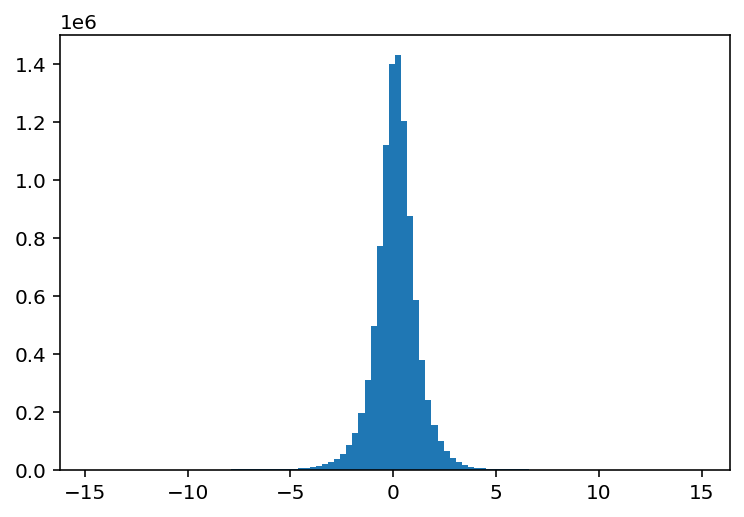

In [46]:
plt.hist(t_diff, bins=100);

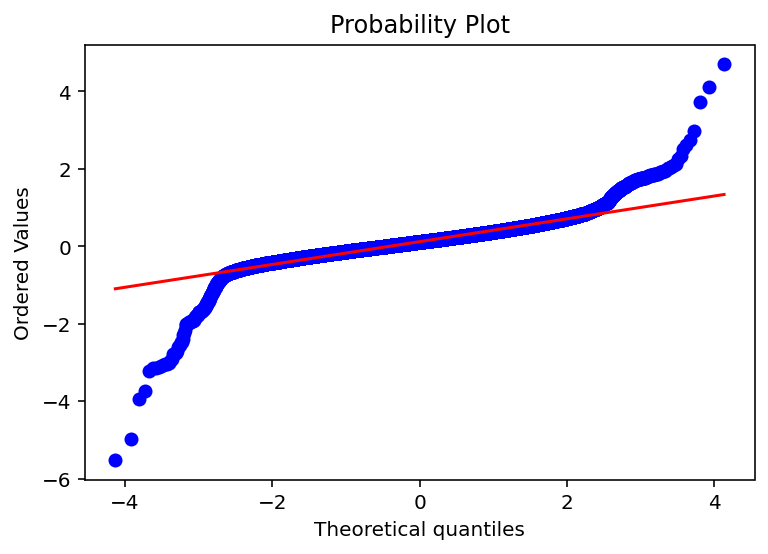

In [43]:
scipy.stats.probplot(t_diff, plot=plt);

In [4]:
print(RAPtrain.shape,  RAPval.shape,  RAPtest.shape)

(28782, 256, 4) (3840, 256, 4) (5733, 256, 4)


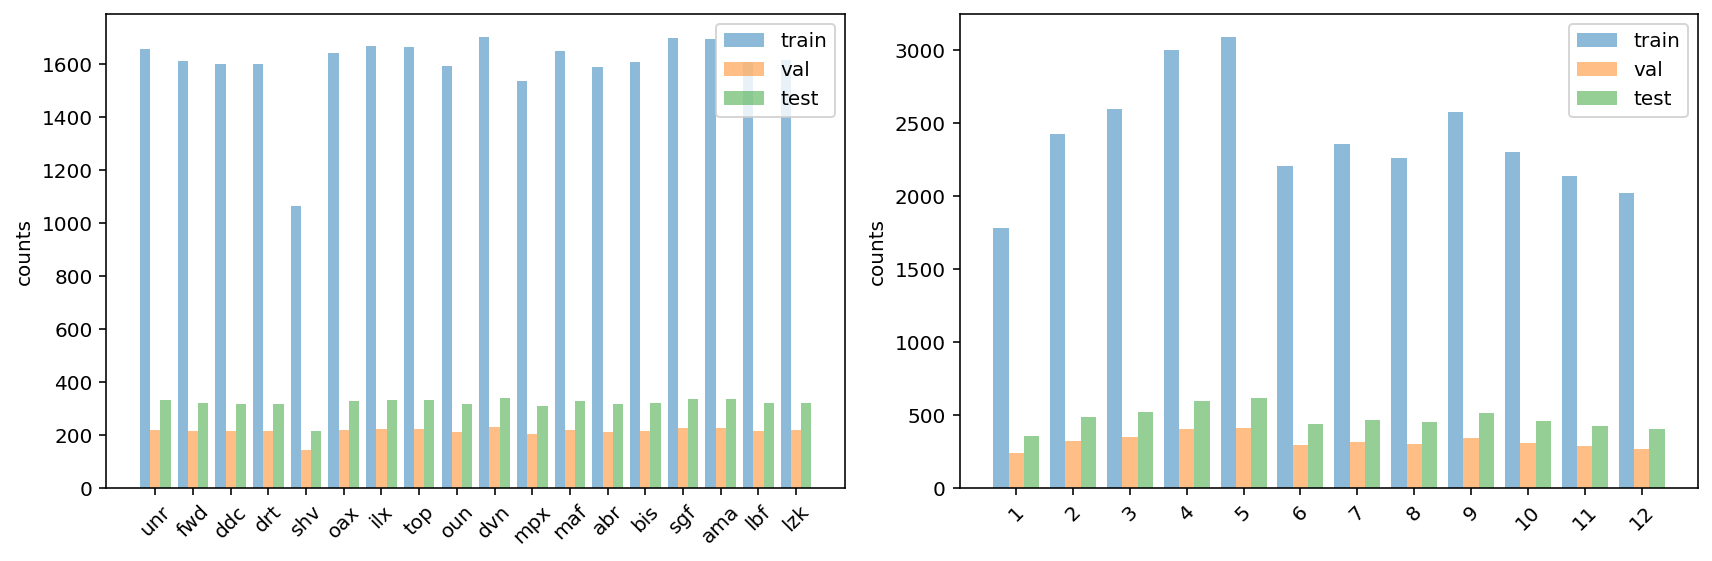

In [5]:
locations = {'bis', 'abr', 'unr', 'lbf', 'oax', 'top',
             'ddc', 'oun', 'ama', 'fwd', 'maf', 'drt',
             'lzk', 'sgf', 'shv', 'dvn', 'ilx', 'mpx'} # 'sgp'
l_ind = np.arange(len(locations))
months = np.arange(1, 13)

width = 0.27 # the width of the bars

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

FILEtrain_content = np.array([f.split('_') for f in FILEtrain])
FILEval_content   = np.array([f.split('_') for f in FILEval])
FILEtest_content  = np.array([f.split('_') for f in FILEtest])

_, counts = np.unique(FILEtrain_content[:,0], return_counts=True)
rects1 = axs[0].bar(l_ind, counts, width, alpha=0.5)
_, counts = np.unique(FILEval_content[:,0], return_counts=True)
rects2 = axs[0].bar(l_ind+width, counts, width, alpha=0.5)
_, counts = np.unique(FILEtest_content[:,0], return_counts=True)
rects3 = axs[0].bar(l_ind+width*2, counts, width, alpha=0.5)

axs[0].set_ylabel('counts')
axs[0].set_xticks(l_ind+width)
axs[0].set_xticklabels(locations, rotation=45)
axs[0].legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

_, counts = np.unique(pd.to_datetime(FILEtrain_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects1 = axs[1].bar(months, counts, width, alpha=0.5)
_, counts = np.unique(pd.to_datetime(FILEval_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects2 = axs[1].bar(months+width, counts, width, alpha=0.5)
_, counts = np.unique(pd.to_datetime(FILEtest_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects3 = axs[1].bar(months+width*2, counts, width, alpha=0.5)

axs[1].set_ylabel('counts')
axs[1].set_xticks(months+width)
axs[1].set_xticklabels(months, rotation=45)
axs[1].legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

fig.tight_layout()

In [6]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [7]:
s = 'test'
print(baseline[f'rap_temperature_{s}_mean_rmse'])
print(baseline[f'rap_temperature_{s}_mean_rmse_sfc'])
print(baseline[f'rap_dewpoint_{s}_mean_rmse'])
print(baseline[f'rap_dewpoint_{s}_mean_rmse_sfc'])

1.0514866227677415
1.0619079297332366
6.178266681033925
3.2435491271550396


In [8]:
def min_max(df):
    min_i = np.inf
    min_v = np.inf
    max_i = 0
    max_v = 0
    for i, row in df.iterrows():
        train_rmse = np.asarray(literal_eval(row[f'root_mean_squared_error']))
        if train_rmse.min() < min_v:
            min_v = train_rmse.min()
            min_i = i
        if train_rmse.max() > max_v:
            max_v = train_rmse.max()
            max_i = i  

        plt.plot(train_rmse)
        plt.plot(np.asarray(literal_eval(row[f'val_root_mean_squared_error'])),'--')

    return min_i, min_v, max_i, max_v

(38373, 256)


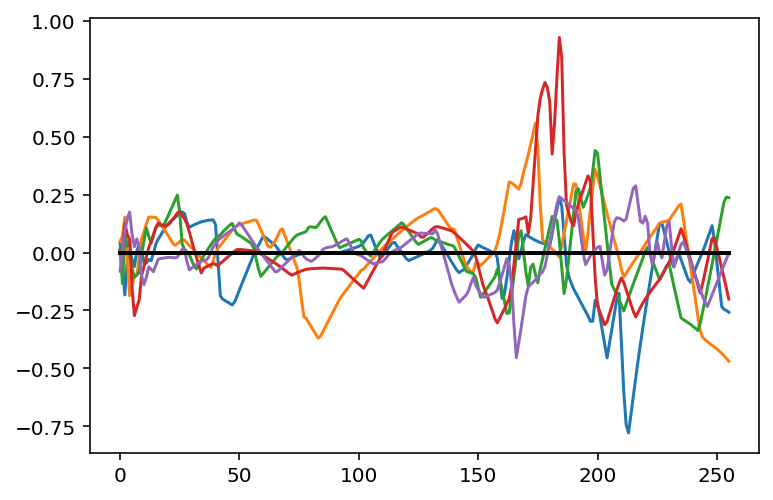

In [9]:
import copy

def _standardizeX(X):
    result = (X - Xmeans) / XstdsFixed
    result[:, Xconstant] = 0.0
    return result

def _unstandardizeX(Xs):
    return Xstds * Xs + Xmeans

def _standardizeT(T):
    result = (T - Tmeans) / TstdsFixed
    result[:, Tconstant] = 0.0
    return result

def _unstandardizeT(Ts):
    return Tstds * Ts + Tmeans

X = rap
T = raob

Xmeans = X.mean(axis=0)
Xstds = X.std(axis=0)
Xconstant = Xstds == 0
XstdsFixed = copy.copy(Xstds)
XstdsFixed[Xconstant] = 1

Tmeans = T.mean(axis=0)
Tstds = T.std(axis=0)
Tconstant = Tstds == 0
TstdsFixed = copy.copy(Tstds)
TstdsFixed[Tconstant] = 1

X = _standardizeX(X)
T = _standardizeT(T)

diff = X[:,:,dl.TEMPERATURE] - T[:,:,dl.TEMPERATURE]
print(diff.shape)
fig, axs = plt.subplots(figsize=(6, 4))
for p in (diff[:5]):
    axs.plot(p)
    
axs.plot(diff.mean(axis=0), color='black', lw=2);

(38373, 256)


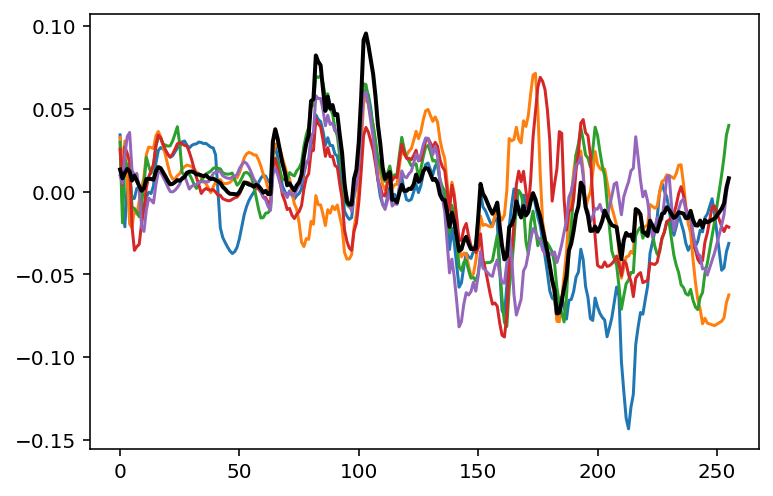

In [11]:
import copy

def _standardizeX(X):
    result = (X - Xmin) / (Xmax - Xmin)
    return result

def _unstandardizeX(Xs):
    return  Xs * (Xmax - Xmin) + Xmin

def _standardizeT(T):
    result = (T - Tmin) / (Tmax - Tmin)
    return result

def _unstandardizeT(Ts):
    return  Ts * (Tmax - Tmin) + Tmin

X = rap
T = raob

Xmin = X.min(axis=0)
Xmax = X.max(axis=0)

Tmin = T.min(axis=0)
Tmax = T.max(axis=0)

X = _standardizeX(X)
T = _standardizeT(T)

diff = X[:,:,dl.TEMPERATURE] - T[:,:,dl.TEMPERATURE]
print(diff.shape)
fig, axs = plt.subplots(figsize=(6, 4))
for p in (diff[:5]):
    axs.plot(p)
    
axs.plot(diff.mean(axis=0), color='black', lw=2);

# Fully Connected

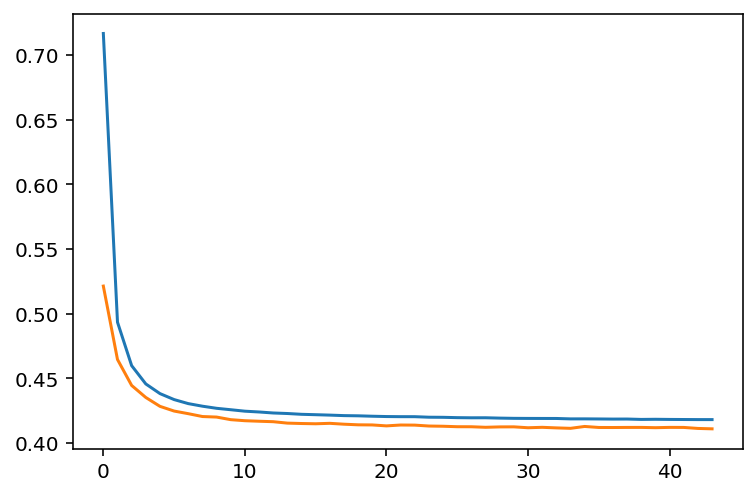

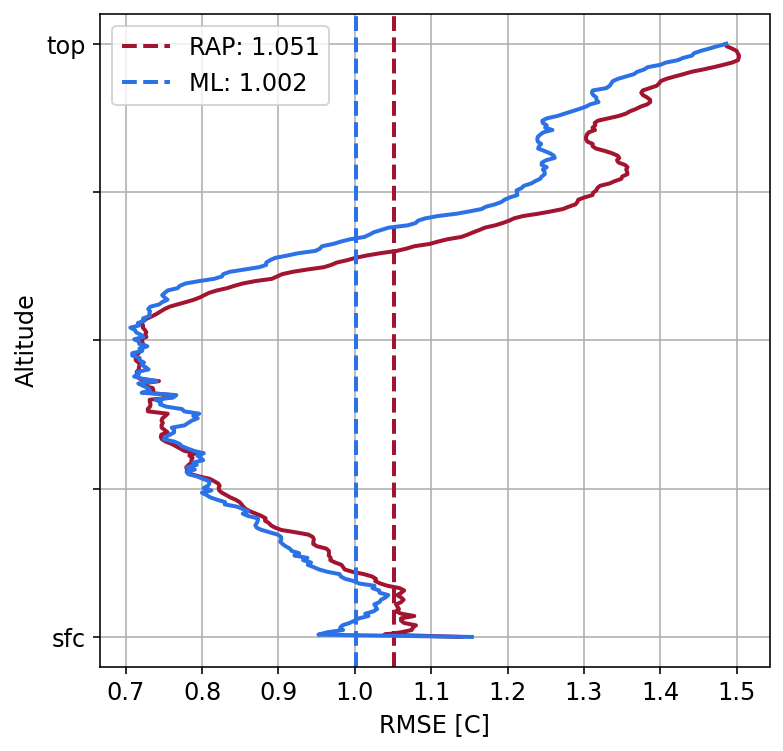

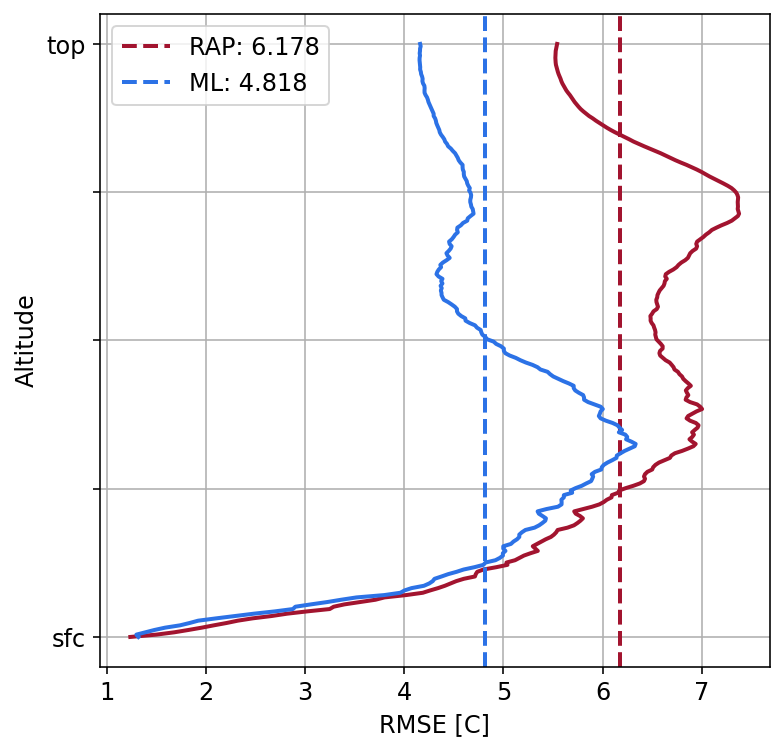

In [602]:
df = pd.read_csv(os.path.join(VOL, 'og_alley_fully_connected_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

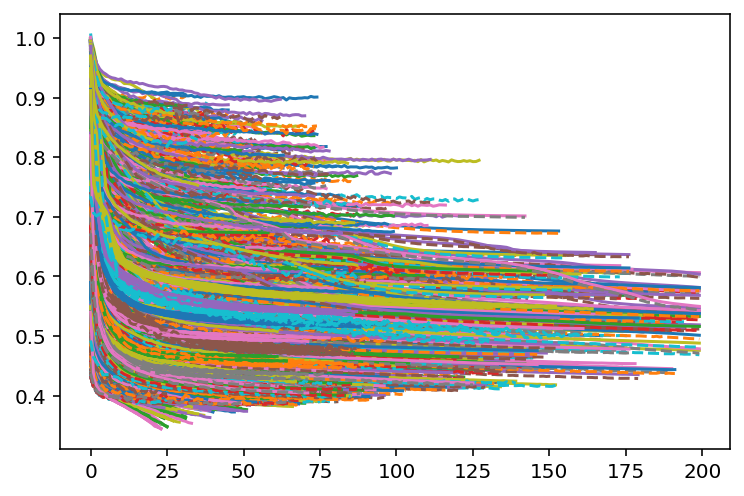

In [442]:
min_i, min_v, max_i, max_v = min_max(df)

In [15]:
np.concatenate([df['rtma_input_channels'].unique(), df['goes_input_channels'].unique(), df['dropout'].unique()])

array(['[]', '[0, 1, 2]', '[]', '[0, 1, 2, 3, 4, 5, 6, 7]', False, True],
      dtype=object)

In [450]:
field = ['ml_temperature_test_mean_rmse', 'ml_dewpoint_test_mean_rmse']
df['test_rmse'] = df[field].mean(axis=1)
trial = df.loc[(df['rtma_input_channels'] == '[0, 1, 2]') & 
               (df['goes_input_channels'] == '[0, 1, 2, 3, 4, 5, 6, 7]') &
               (df['dropout'] == False) &
               (df['hiddens'] == '[512]')]

trial[field].sem(axis=1).mean(), trial[field].mean(axis=1).sem()

(1.7745888192396202, 0.007872016266421328)

In [468]:
trial[field].sem().mean()

0.008014820231664364

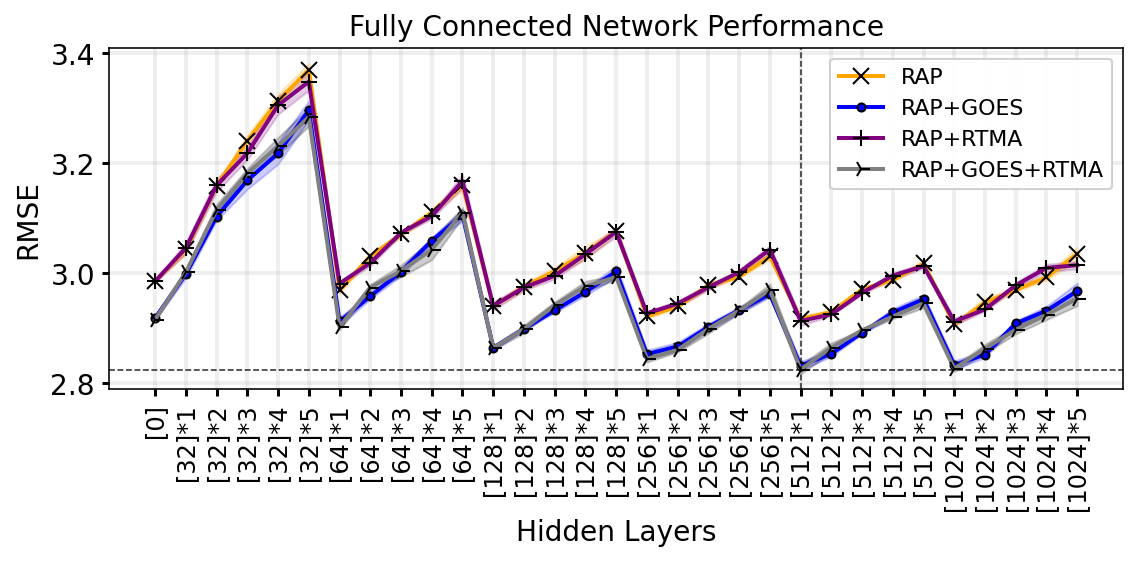

In [603]:
def trial_results(rtma_input_channels, goes_input_channels, dropout):
    results = dict()
    field = ['ml_temperature_test_mean_rmse', 'ml_dewpoint_test_mean_rmse']
    for h in df['hiddens'].unique():
        # skip units
        if literal_eval(h)[0] not in [4, 8, 16]:
            trial = df.loc[(df['rtma_input_channels'] == rtma_input_channels) & 
                           (df['goes_input_channels'] == goes_input_channels) &
                           (df['dropout'] == dropout) &
                           (df['hiddens'] == h)]

            trial_t_mean = trial[field].mean().mean()
            trial_t_sem = trial[field].sem().mean()
            results[h] = (trial_t_mean, trial_t_sem)
            
    return OrderedDict(sorted(results.items(), key=lambda t: literal_eval(list(t)[0])[0]))

fig, ax = plt.subplots(figsize=(8,4))

linewidth = 2

results = trial_results('[]', '[]', False)
mean_sem = np.array(list(results.values()))

ax.plot(range(len(results)), mean_sem[:,0], '-x', markersize=8, color='orange', 
        markeredgecolor='k', linewidth=linewidth, label='RAP')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='orange', alpha=0.2)

results = trial_results('[]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))

ax.plot(range(len(results)), mean_sem[:,0], '-', marker='.', markersize=8, color='blue', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='blue', alpha=0.2)

results = trial_results('[0, 1, 2]', '[]', False)
mean_sem = np.array(list(results.values()))

ax.plot(range(len(results)), mean_sem[:,0], '-+', markersize=8, color='purple',
        markeredgecolor='k', linewidth=linewidth, label='RAP+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='purple', alpha=0.2)

results = trial_results('[0, 1, 2]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))
min_err = min(mean_sem[:,0])
min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-4', markersize=9, color='gray', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='black', alpha=0.2)

# minimum 
plt.axhline(y=min_err, color='k', linestyle='--', alpha=0.8, linewidth=0.8)
plt.axvline(x=min_err_i, color='k', linestyle='--', alpha=0.8, linewidth=0.8)

ax.set_xticks(range(len(results)))

labels = list(results.keys())
labels = []

for l in list(results.keys()):
    a = literal_eval(l)
    labels.append(f'[{str(a[0])}]*{len(a)}' if a[0] not in [0] else l)

default_font = 14
ax.set_xticklabels(labels);
ax.tick_params(axis='x', width=1.5, labelsize=12, rotation=90)
ax.tick_params(axis='y', width=1.5, labelsize=default_font)
ax.set_ylabel('RMSE', fontsize=default_font); ax.set_xlabel('Hidden Layers', fontsize=default_font)
ax.set_title('Fully Connected Network Performance', fontsize=default_font)
ax.grid(True, alpha=0.2, linewidth=linewidth)
plt.tight_layout()

legend1 = plt.legend(ncol=1, fontsize=11)
ax.add_artist(legend1)
plt.setp(legend1.get_title(),fontsize=default_font)

plt.savefig('/home/stock/research/media/fully_connected_rmse_results.pdf', dpi=300)

In [498]:
df = pd.read_csv(os.path.join(VOL, '512_alley_fully_connected_model_temperature_dewpoint.csv'))

df.sort_values(['ml_temperature_test_mean_rmse']).head()

rap_input_dims rap_output_dims rtma_input_channels  \
0   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
4   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
8   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
2   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
6   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   

        goes_input_channels  n_network_inputs     hiddens  n_network_outputs  \
0  [0, 1, 2, 3, 4, 5, 6, 7]              1035       [512]                512   
4  [0, 1, 2, 3, 4, 5, 6, 7]              1035       [512]                512   
8  [0, 1, 2, 3, 4, 5, 6, 7]              1035  [512, 512]                512   
2  [0, 1, 2, 3, 4, 5, 6, 7]              1035       [512]                512   
6  [0, 1, 2, 3, 4, 5, 6, 7]              1035       [512]                512   

  optim      lr activ loss_f  n_epochs  batch_size  dropout  batchnorm  \
0  adam  0.0001  relu    MSE       200         128    False      False   
4  adam  0.0001  relu    MSE       200         128     True      False   
8  adam  0.0001  relu    MSE       200         128    False      False   
2  adam  0.0001  relu    MSE       200         128    False       True   
6  adam  0.0001  relu    MSE       200         128     True       True   

   regularization                                               loss  \
0           False  [0.42174088954925537, 0.22169022262096405, 0.1...   
4           False  [0.5096278190612793, 0.27822649478912354, 0.24...   
8           False  [0.39998769760131836, 0.2090548574924469, 0.18...   
2           False  [0.4337399899959564, 0.23390622437000275, 0.21...   
6           False  [0.5565674304962158, 0.34400609135627747, 0.30...   

                             root_mean_squared_error  \
0  [0.6494157910346985, 0.4708399176597595, 0.444...   
4  [0.7138822078704834, 0.5274717807769775, 0.490...   
8  [0.6324458122253418, 0.45722517371177673, 0.43...   
2  [0.6585894227027893, 0.4836385250091553, 0.458...   
6  [0.7460344433784485, 0.5865203142166138, 0.552...   

                                  mean_squared_error  \
0  [0.42174088954925537, 0.22169022262096405, 0.1...   
4  [0.5096278190612793, 0.27822649478912354, 0.24...   
8  [0.39998769760131836, 0.2090548574924469, 0.18...   
2  [0.4337399899959564, 0.23390622437000275, 0.21...   
6  [0.5565674304962158, 0.34400609135627747, 0.30...   

                                 mean_absolute_error  \
0  [0.4684278666973114, 0.32586222887039185, 0.29...   
4  [0.5305471420288086, 0.3839235007762909, 0.349...   
8  [0.45656007528305054, 0.3128865957260132, 0.28...   
2  [0.4801394045352936, 0.3417103886604309, 0.317...   
6  [0.5613040924072266, 0.4390324652194977, 0.409...   

                                            val_loss  \
0  [0.24012070894241333, 0.2003209888935089, 0.18...   
4  [0.24970944225788116, 0.20489491522312164, 0.1...   
8  [0.22270150482654572, 0.1895211637020111, 0.17...   
2  [0.2518399655818939, 0.20556022226810455, 0.18...   
6  [0.25716403126716614, 0.21060608327388763, 0.1...   

                         val_root_mean_squared_error  \
0  [0.49002113938331604, 0.4475723206996918, 0.43...   
4  [0.4997093677520752, 0.4526531994342804, 0.435...   
8  [0.47191259264945984, 0.4353402853012085, 0.42...   
2  [0.5018365979194641, 0.4533874988555908, 0.435...   
6  [0.5071134567260742, 0.45891839265823364, 0.44...   

                              val_mean_squared_error  \
0  [0.24012070894241333, 0.2003209888935089, 0.18...   
4  [0.24970944225788116, 0.20489491522312164, 0.1...   
8  [0.22270150482654572, 0.1895211637020111, 0.17...   
2  [0.2518399655818939, 0.20556022226810455, 0.18...   
6  [0.25716403126716614, 0.21060608327388763, 0.1...   

                             val_mean_absolute_error  \
0  [0.34863775968551636, 0.3062369227409363, 0.29...   
4  [0.3581930994987488, 0.31237754225730896, 0.29...   
8  [0.33276626467704773, 0.2966362535953522, 0.28...   
2  [0.36315515637397766, 0.3138704299926758, 0.29...   
6  [

[512, 512, 512, 512, 512]


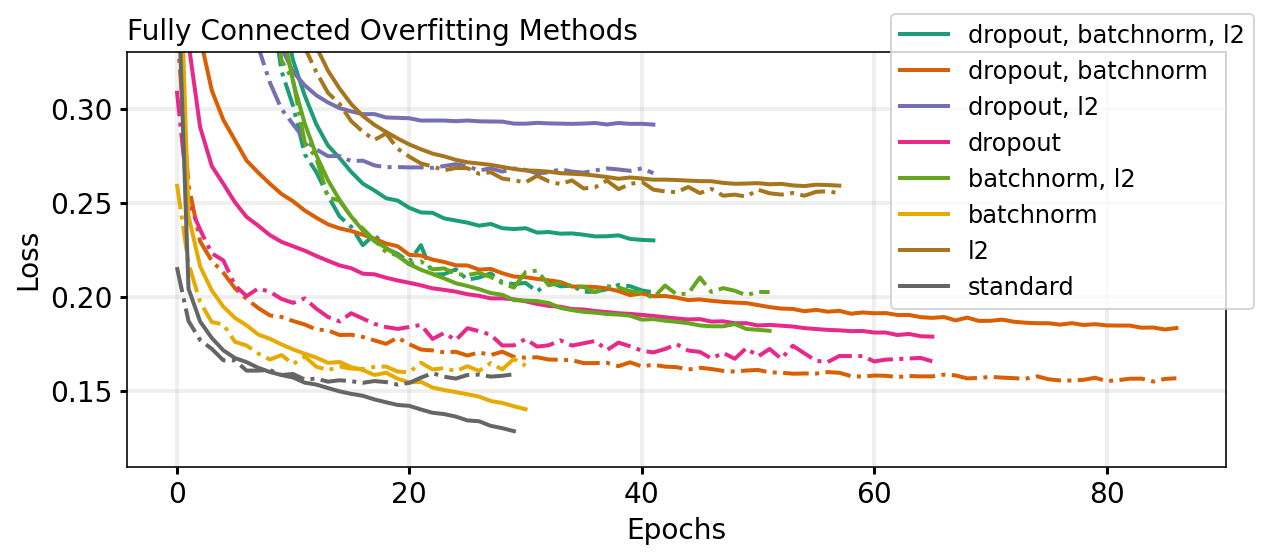

In [499]:
fig, ax = plt.subplots(figsize=(9,4))

units = 512
colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
linewidth = 2
default_font = 14
i = 0
layer = [units]*5
field = ['ml_temperature_test_mean_rmse', 'ml_dewpoint_test_mean_rmse']
for dropout, batchnorm, regularization in list(itertools.product([True, False], 
                                                                 [True, False], 
                                                                 [True, False])):
    trial = df.loc[(df['dropout'] == dropout) &
                   (df['batchnorm'] == batchnorm) &
                   (df['regularization'] == regularization) &
                   (df['hiddens'] == str(layer))].reset_index(drop=True)
    t = trial[field].mean(axis=1).sort_values().index[0]
    temp = list(itertools.compress(['dropout', 'batchnorm', 'l2'],
                                   [dropout, batchnorm, regularization]))
    label = ', '.join(temp) if len(temp) else 'standard'
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[i], label=label, linewidth=linewidth)
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[i], linewidth=linewidth)
    
    i += 1
    
print(layer)

ax.set_ylim((0.11, .33))
ax.grid(True, alpha=0.2, linewidth=linewidth)
ax.legend(loc='upper center', bbox_to_anchor=(0.86, 1.12), ncol=1, fontsize=12) # (0.5, 1.25)
ax.set_ylabel('Loss', fontsize=default_font)
ax.set_xlabel('Epochs', fontsize=default_font)
ax.tick_params('both', width=1.5, labelsize=default_font)
ax.set_title('Fully Connected Overfitting Methods', loc='left', fontsize=default_font)
plt.tight_layout()
plt.savefig(f'/home/stock/research/media/512_{len(layer)}_overfitting_results.pdf', dpi=300)

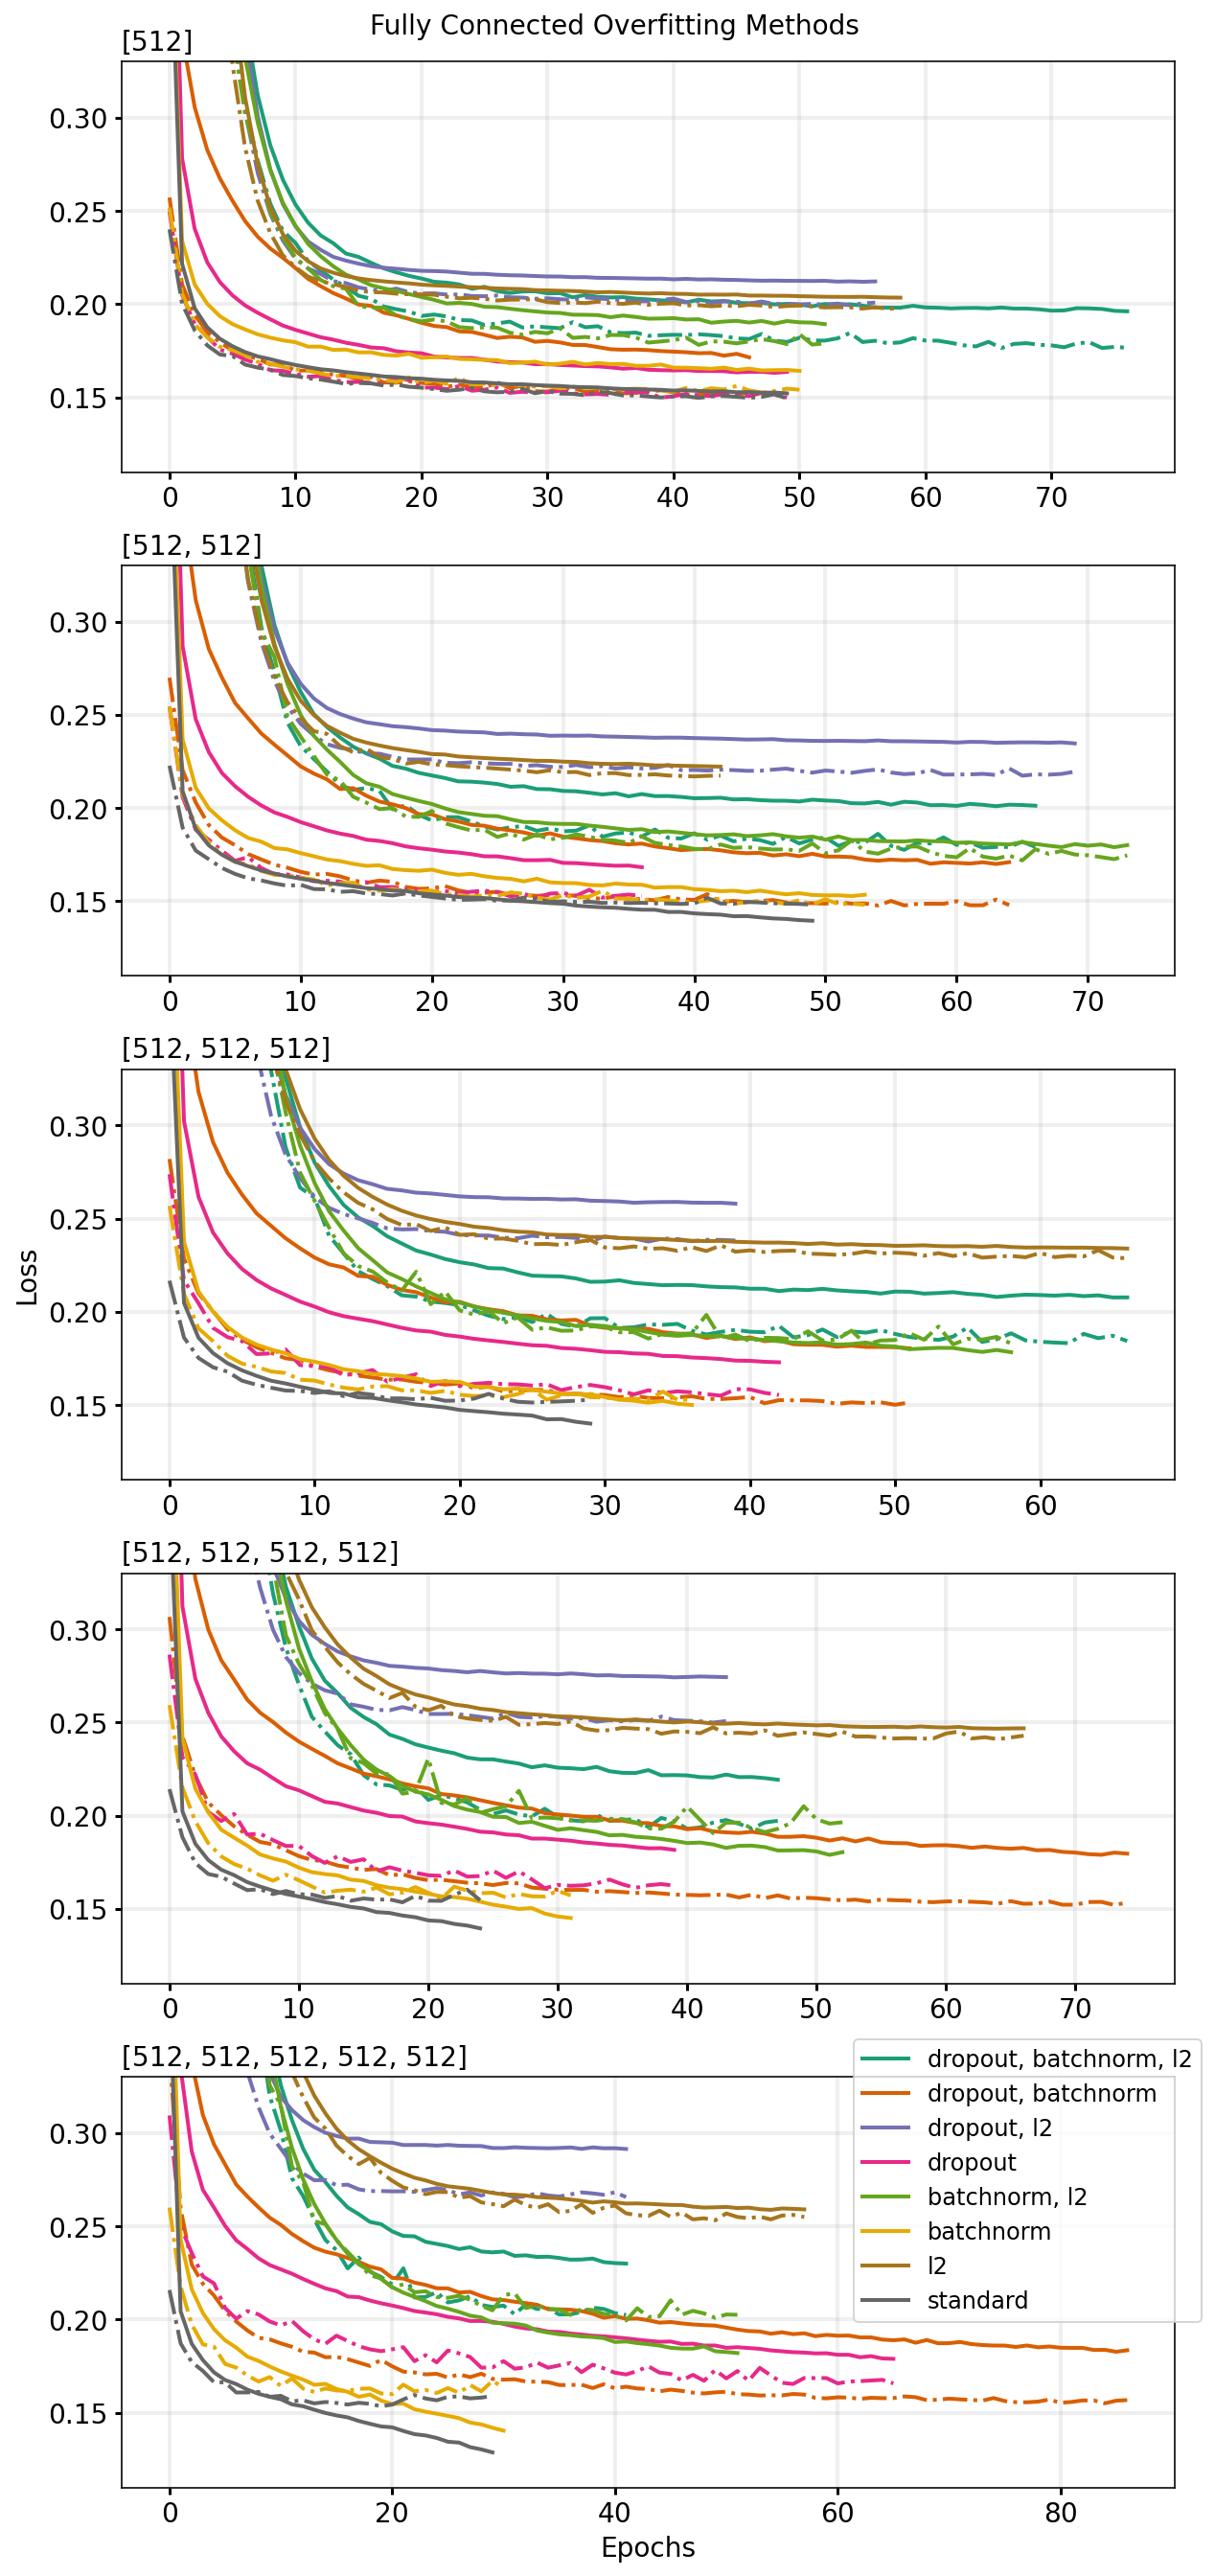

In [500]:
fig, axs = plt.subplots(5, 1, figsize=(9,19))
axs = np.ravel(axs)

units = 512
colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
linewidth = 2
default_font = 14
i = 0
field = ['ml_temperature_test_mean_rmse', 'ml_dewpoint_test_mean_rmse']
for i in range(5):
    layer = [units]*(i+1)
    j = 0
    for dropout, batchnorm, regularization in list(itertools.product([True, False], 
                                                                     [True, False], 
                                                                     [True, False])):
        trial = df.loc[(df['dropout'] == dropout) &
                       (df['batchnorm'] == batchnorm) &
                       (df['regularization'] == regularization) &
                       (df['hiddens'] == str(layer))].reset_index(drop=True)
        t = trial[field].mean(axis=1).sort_values().index[0]
        temp = list(itertools.compress(['dropout', 'batchnorm', 'l2'],
                                       [dropout, batchnorm, regularization]))
        if i == 4:
            label = ', '.join(temp) if len(temp) else 'standard'
        else:
            label = None
        axs[i].plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[j], label=label, linewidth=linewidth)
        axs[i].plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[j], linewidth=linewidth)
        j += 1
    
    axs[i].set_ylim((0.11, .33))
    axs[i].grid(True, alpha=0.2, linewidth=linewidth)
    axs[i].tick_params('both', width=1.5, labelsize=default_font)
    axs[i].set_title(str(layer), loc='left', fontsize=default_font)

axs[2].set_ylabel('Loss', fontsize=default_font)   
axs[4].legend(loc='upper center', bbox_to_anchor=(0.86, 1.12), ncol=1, fontsize=12) # (0.5, 1.25)
axs[4].set_xlabel('Epochs', fontsize=default_font)

fig.suptitle('Fully Connected Overfitting Methods', fontsize=default_font)
fig.tight_layout()
plt.savefig(f'/home/stock/research/media/{str(units)}_overfitting_results.pdf', dpi=300)

# Convolutional

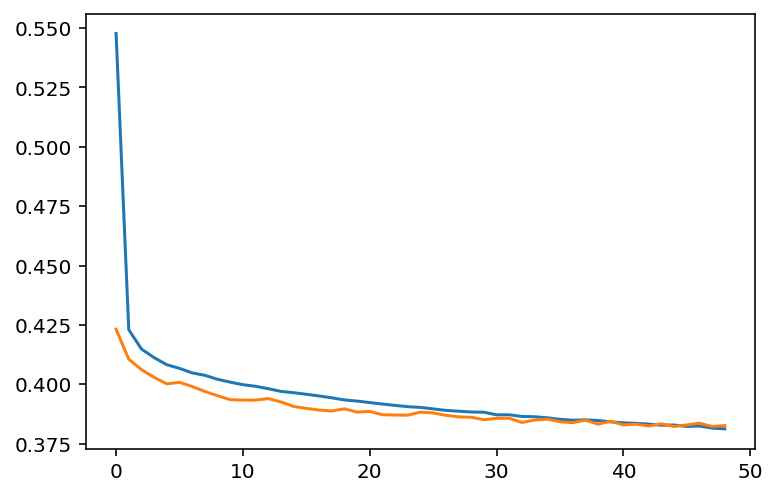

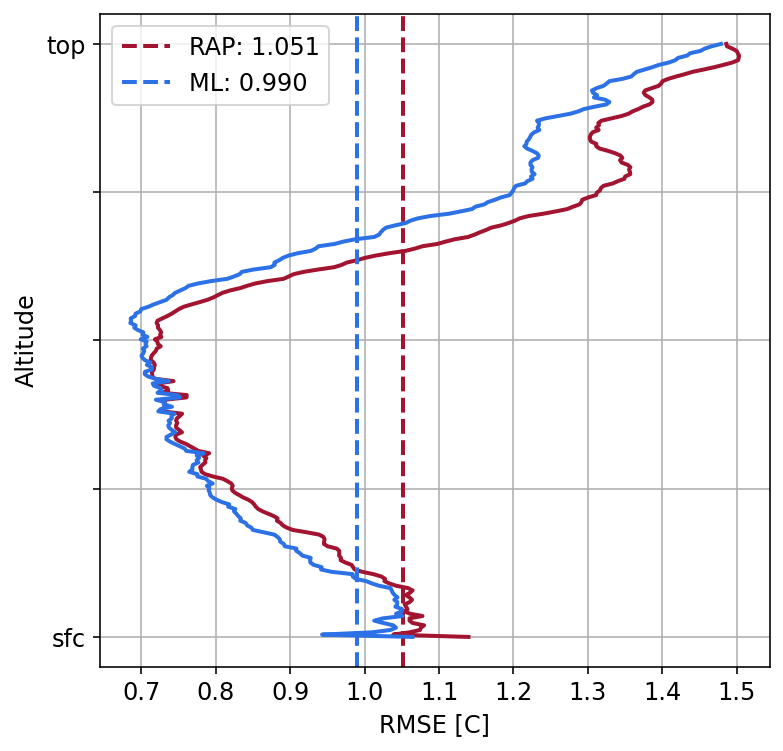

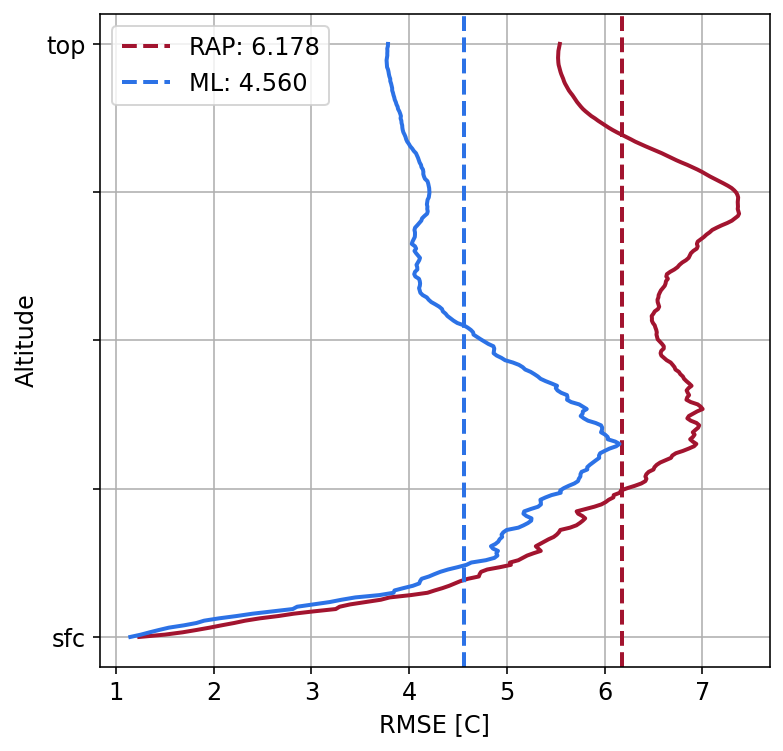

In [604]:
df = pd.read_csv(os.path.join(VOL, 'alley_multi_cnn_model_temperature_dewpoint.csv'))
# replace [] with [0]
df.loc[(df['hiddens'] == '[]'), 'hiddens'] = '[0]'

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

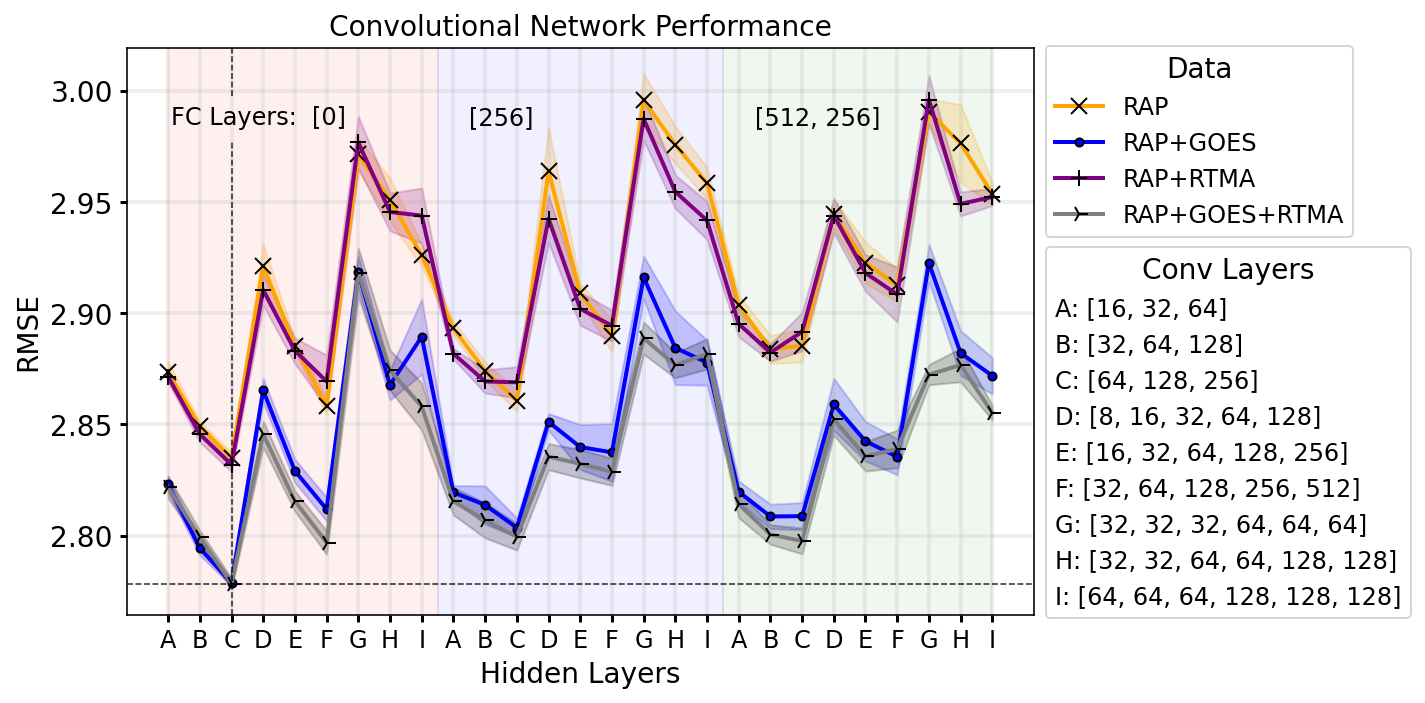

In [609]:
def trial_results(rtma_input_channels, goes_input_channels, dropout):
    results = dict()
    field = ['ml_temperature_test_mean_rmse', 'ml_dewpoint_test_mean_rmse']
    for h in df['hiddens'].unique():
        for c in df['n_units_in_conv_layers'].unique():
            trial = df.loc[(df['rtma_input_channels'] == rtma_input_channels) & 
                           (df['goes_input_channels'] == goes_input_channels) &
                           (df['dropout'] == dropout) &
                           (df['hiddens'] == h) &
                           (df['n_units_in_conv_layers'] == c)]

            trial_t_mean = trial[field].mean().mean() # mean of all trials, then mean of fields
            trial_t_sem = trial[field].sem().mean()
            results[h+'|'+c] = (trial_t_mean, trial_t_sem)
            
    return OrderedDict(sorted(results.items(), key=lambda t: len(t[0].split('|')[0])))

fig, ax = plt.subplots(figsize=(10,5))

linewidth = 2

span_alpha = 0.06
ax.axvspan(0, 8.5, alpha=span_alpha, color='red')
ax.text(0.1, 2.985, 'FC Layers:  [0]', fontsize=12)
ax.axvspan(8.5, 17.5, alpha=span_alpha, color='blue')
ax.text(9.5, 2.985, '[256]', fontsize=12)
ax.axvspan(17.5, 26, alpha=span_alpha, color='green')
ax.text(18.5, 2.985, '[512, 256]', fontsize=12)

results = trial_results('[]', '[]', False)
mean_sem = np.array(list(results.values()))

ax.plot(range(len(results)), mean_sem[:,0], '-x', markersize=8, color='orange', 
        markeredgecolor='k', linewidth=linewidth, label='RAP')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='orange', alpha=0.2)

results = trial_results('[]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))

ax.plot(range(len(results)), mean_sem[:,0], '-', marker='.', markersize=8, color='blue', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='blue', alpha=0.2)

results = trial_results('[0, 1, 2]', '[]', False)
mean_sem = np.array(list(results.values()))

ax.plot(range(len(results)), mean_sem[:,0], '-+', markersize=8, color='purple',
        markeredgecolor='k', linewidth=linewidth, label='RAP+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='purple', alpha=0.2)

results = trial_results('[0, 1, 2]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))
min_err = min(mean_sem[:,0])
min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-4', markersize=9, color='gray', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='black', alpha=0.2)

# minimum 
ax.axhline(y=min_err, color='k', linestyle='--', alpha=0.8, linewidth=0.8)
ax.axvline(x=min_err_i, ymin=0.915, color='k', linestyle='--', alpha=0.8, linewidth=0.8)
ax.axvline(x=min_err_i, ymax=0.835, color='k', linestyle='--', alpha=0.8, linewidth=0.8)

labels = np.tile([i for i in string.ascii_uppercase[:9]], 3) # list(results.keys())
default_font = 14

ax.set_xticks(range(len(results)))
ax.set_xticklabels(labels);
ax.tick_params(axis='x', width=1.5, labelsize=12, rotation=0)
ax.tick_params(axis='y', width=1.5, labelsize=default_font)
ax.set_ylabel('RMSE', fontsize=default_font); ax.set_xlabel('Hidden Layers', fontsize=default_font)
ax.set_title('Convolutional Network Performance', fontsize=default_font)
ax.grid(True, alpha=0.2, linewidth=linewidth)

layers = df['n_units_in_conv_layers'].unique()
letters = [i for i in string.ascii_uppercase[:9]]
labels = [': '.join([s[0], s[1]]) for s in list(zip(letters, layers))]
proxies = [matplotlib.lines.Line2D([],[], markerfacecolor='w', markeredgecolor='w') for _ in range(len(labels))]

legend1 = plt.legend(bbox_to_anchor=(1.0, 1.025), ncol=1, fontsize=12, title='Data')
ax.add_artist(legend1)
plt.setp(legend1.get_title(),fontsize=default_font)

legend2 = ax.legend(proxies, labels, handletextpad=0, handlelength=0, bbox_to_anchor=(1.0, 0.67), 
                    ncol=1, fontsize=12, title='Conv Layers');
plt.setp(legend2.get_title(),fontsize=default_font)
fig.tight_layout()
plt.savefig('/home/stock/research/media/cnn_rmse_results_line.pdf', dpi=300)

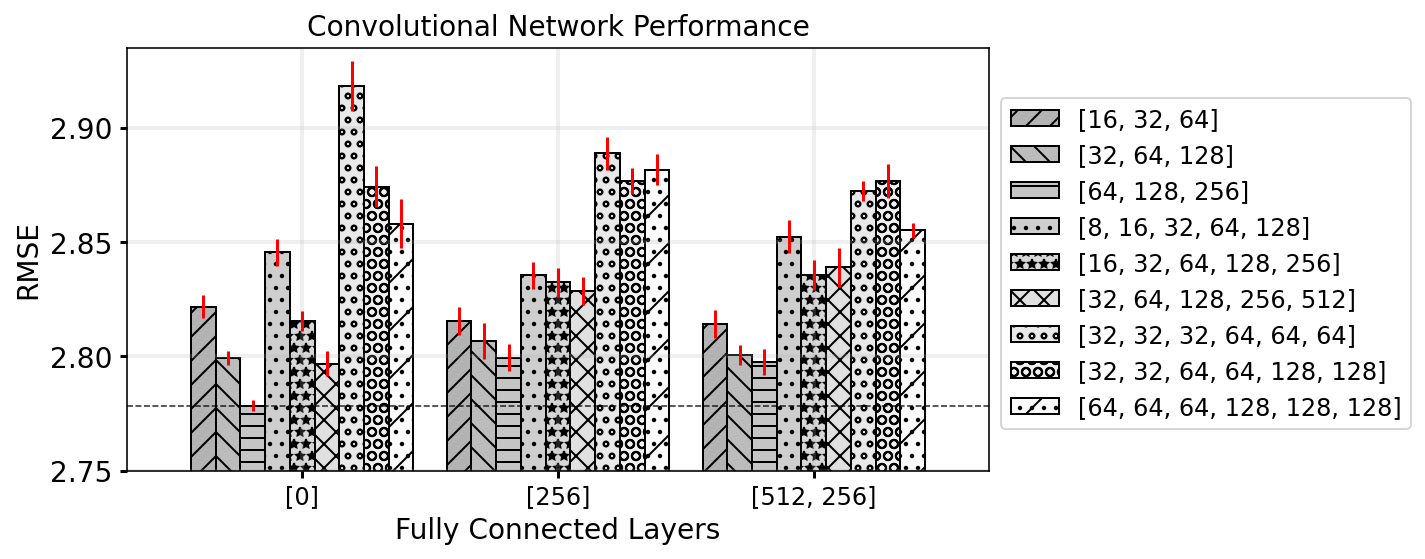

In [482]:
groups = []
group_values = []
for c in df['n_units_in_conv_layers'].unique():
    groups.append(c)
    l = []
    for key in results.keys():
        if c in key:
            l.append(results[key])
    group_values.append(l)
    
group_values = np.array(group_values)

columns = ['A', 'Ae', 'B', 'Be', 'C', 'Ce', 'D', 'De', 'E',
           'Ee', 'F', 'Fe', 'G', 'Ge', 'H', 'He', 'I', 'Ie']
dd = pd.DataFrame(np.array([list(group_values[:,i,:].flatten()) for i in range(3)]), 
                  columns = columns, index=['[0]', '[256]', '[512, 256]'])

colors = plt.cm.gray(np.linspace(0.70,0.98,9)) # tab10

fig, ax = plt.subplots(figsize=(10,4))

dd[[i for i in string.ascii_uppercase[:9]]].plot(kind='bar',yerr=dd[['Ae', 'Be', 'Ce', 'De', 'Ee',
                                                                           'Fe', 'Ge', 'He', 'Ie']].values.T, 
                                                       rot=0, error_kw=dict(ecolor='r'),width=0.87, 
                                                       ax=ax, color=colors, edgecolor='k');
bars = ax.patches
patterns = ['//', '\\\\', '--', '..', '**', 'xx', 'oo', 'OO', '/..']
hatches = [p for p in patterns for i in range(len(dd))]

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)


ax.set_ylim((2.75, 2.935))

ax.tick_params(axis='x', width=1.5, labelsize=12, rotation=0)
ax.tick_params(axis='y', width=1.5, labelsize=default_font)
ax.set_ylabel('RMSE', fontsize=default_font); ax.set_xlabel('Fully Connected Layers', fontsize=default_font)
ax.set_title('Convolutional Network Performance', fontsize=default_font)
ax.grid(True, alpha=0.2, linewidth=linewidth)
ax.legend(groups, bbox_to_anchor=(1.0, 0.91), ncol=1, fontsize=12)

ax.axhline(y=group_values[:,:,0].min(), color='k', linestyle='--', alpha=0.8, linewidth=0.8, label=None);

fig.tight_layout()
plt.savefig('/home/stock/research/media/cnn_rmse_results_bar.pdf', dpi=300)

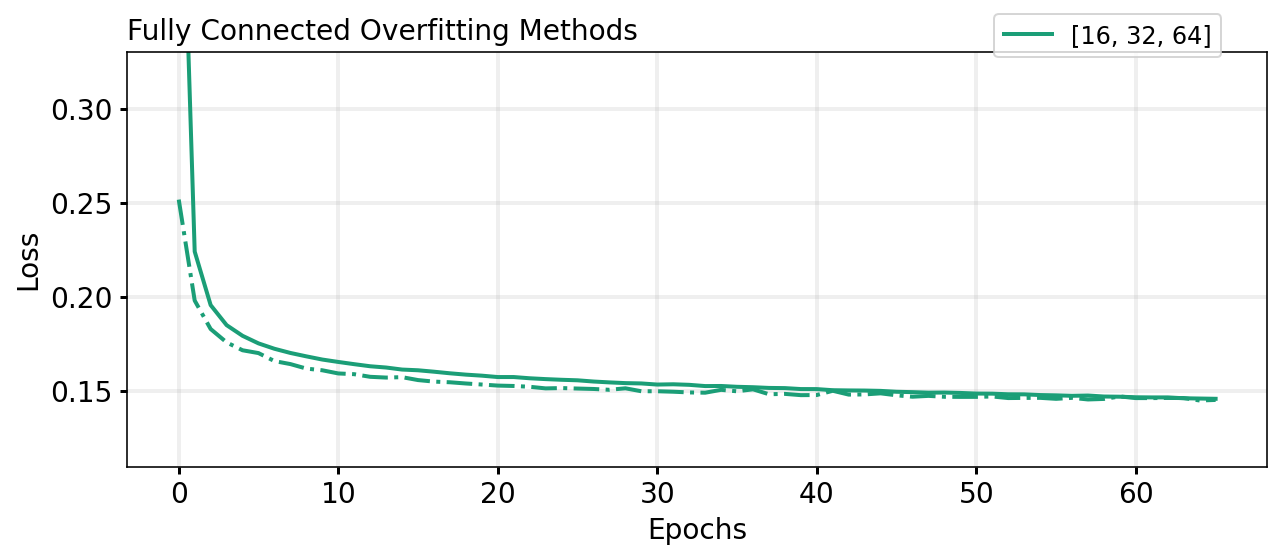

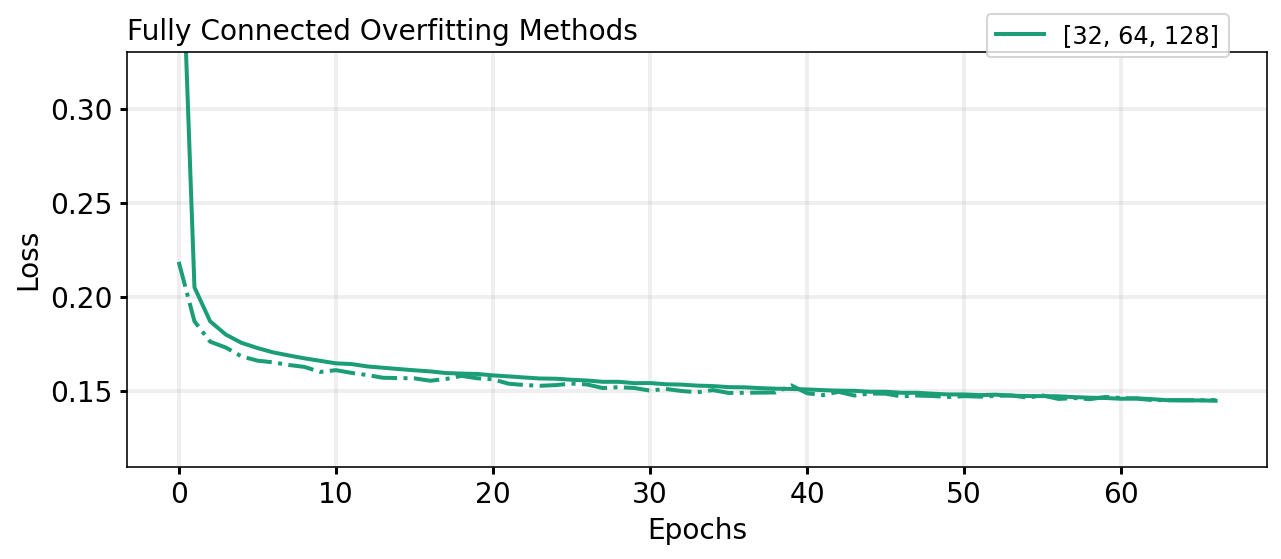

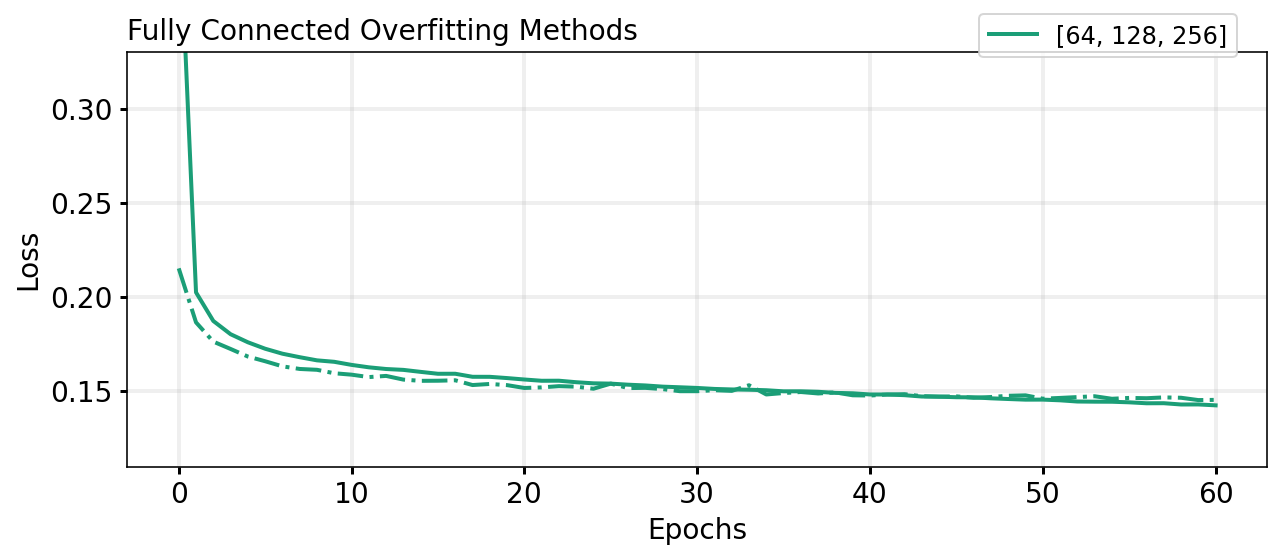

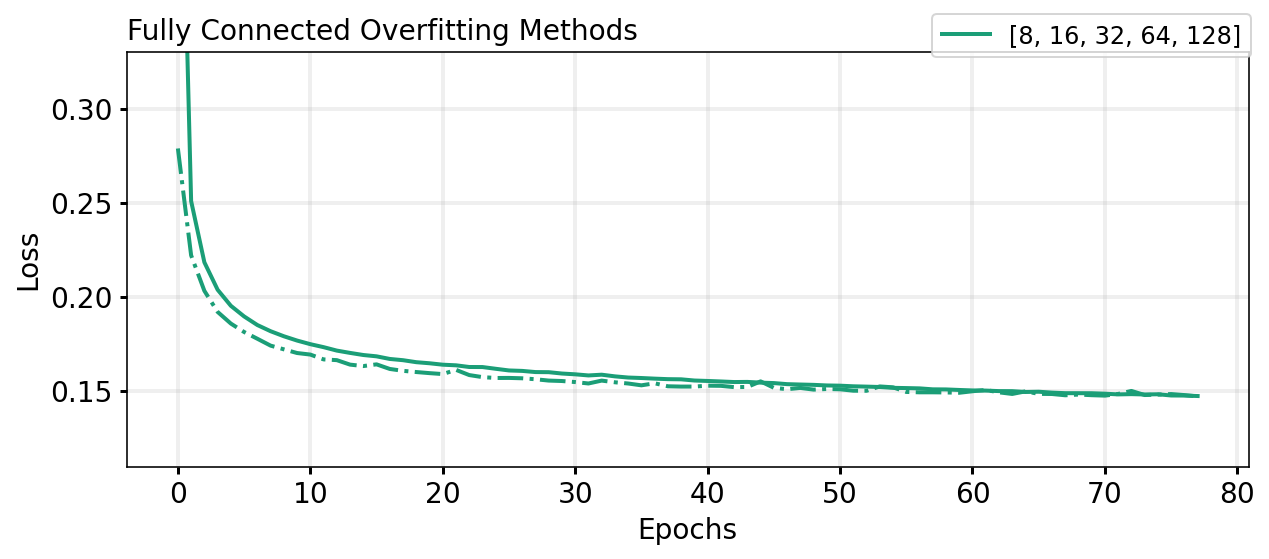

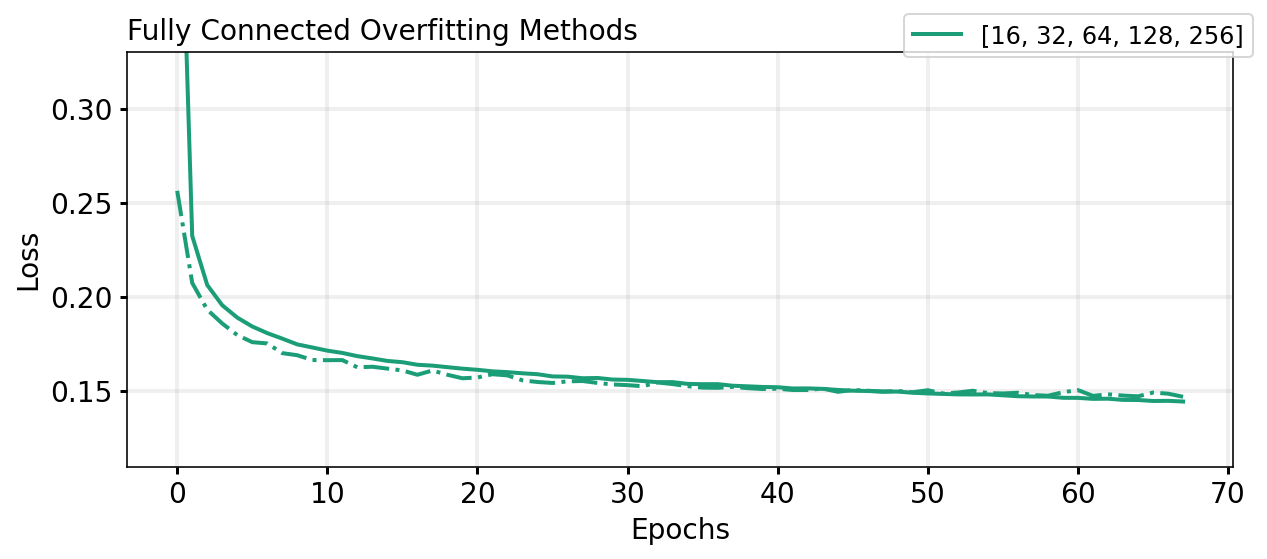

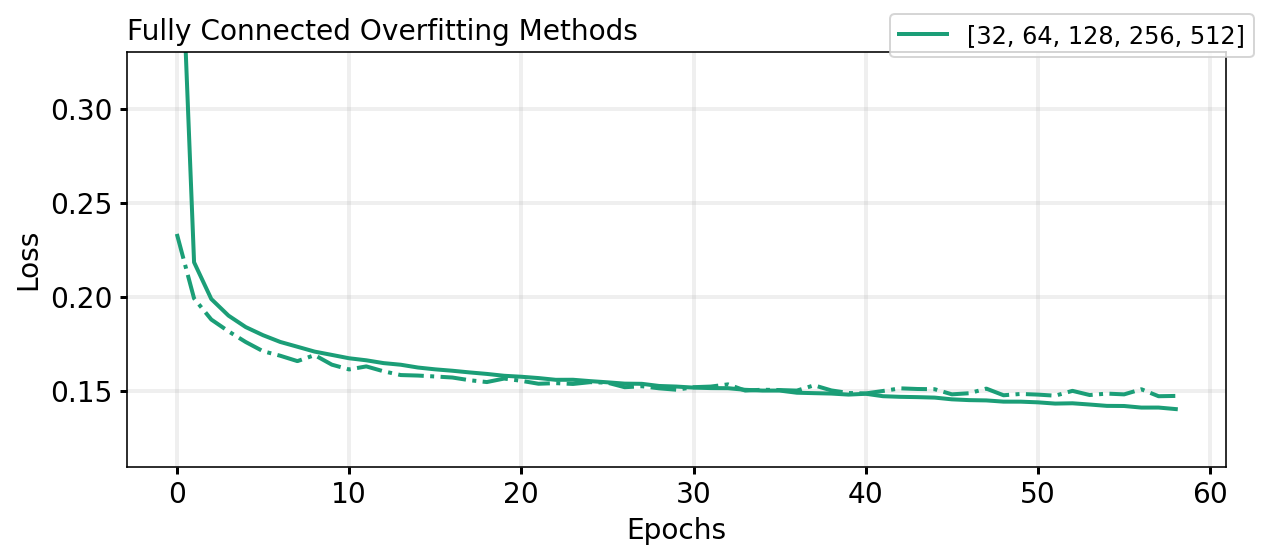

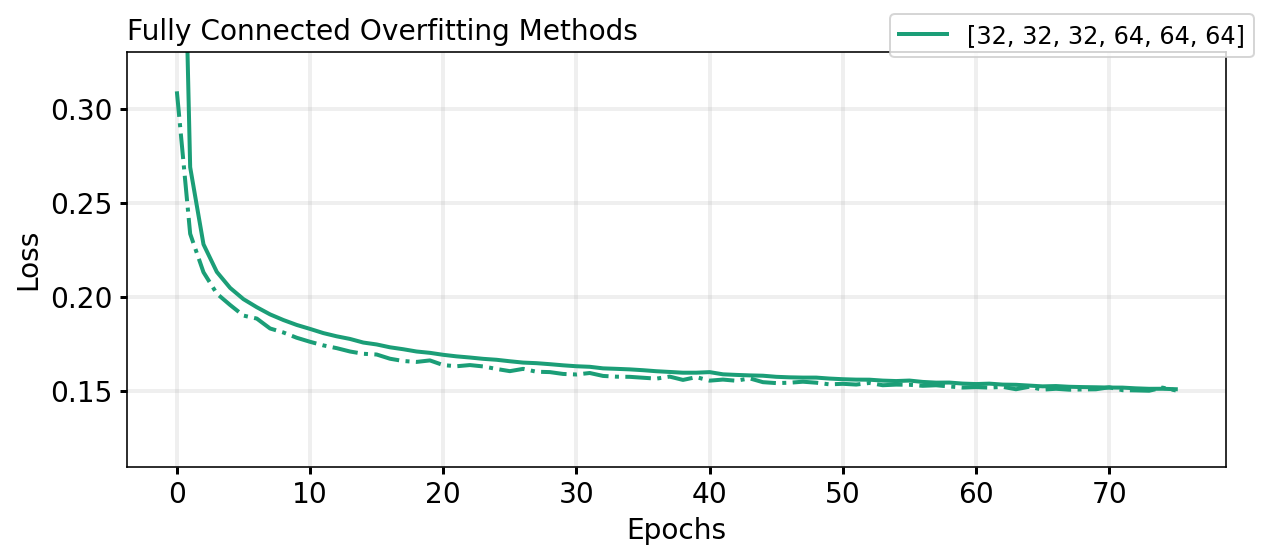

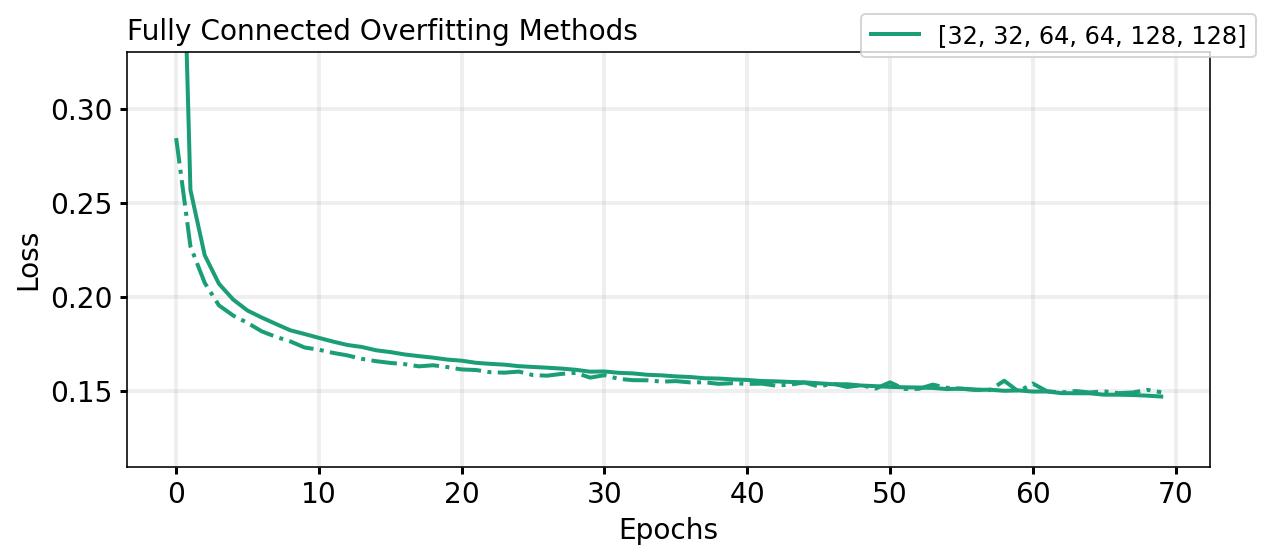

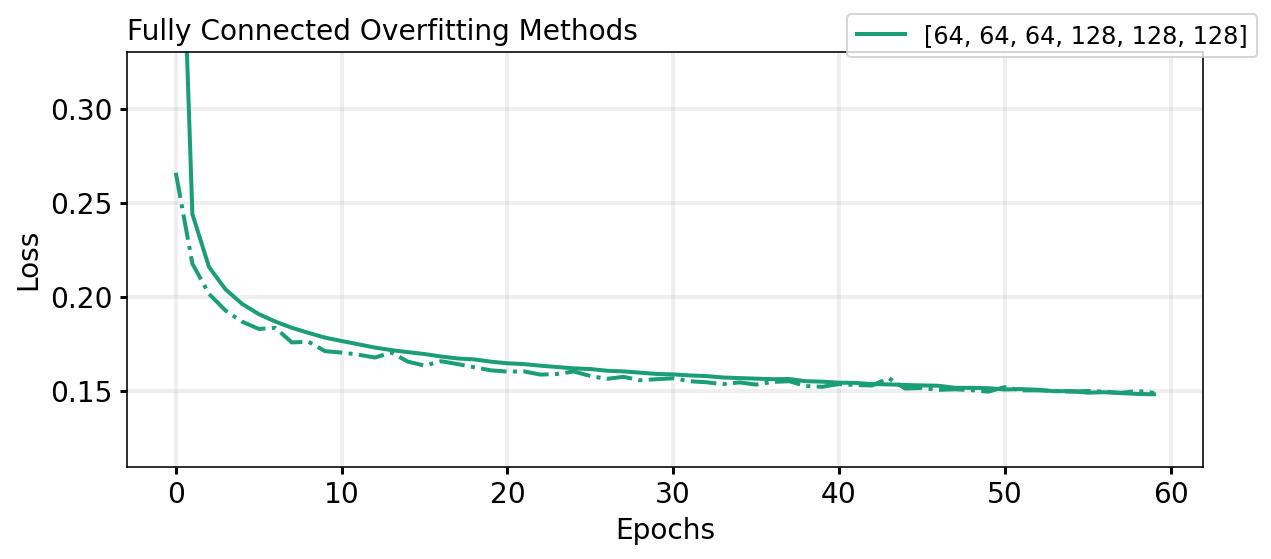

In [616]:
for c in df['n_units_in_conv_layers'].unique():
    fig, ax = plt.subplots(figsize=(9,4))
    colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
    linewidth = 2
    default_font = 14
    i = 0
    field = ['ml_temperature_test_mean_rmse', 'ml_dewpoint_test_mean_rmse']

    trial = df.loc[(df['rtma_input_channels'] == '[0, 1, 2]') & 
                   (df['goes_input_channels'] == '[0, 1, 2, 3, 4, 5, 6, 7]') &
                   (df['n_units_in_conv_layers'] == c) &
                   (df['hiddens'] == '[256]')].reset_index(drop=True)

    t = trial[field].mean(axis=1).sort_values().index[0]
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[i], label=c, linewidth=linewidth)
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[i], linewidth=linewidth)
    i += 1
    ax.set_ylim((0.11, .33))
    ax.grid(True, alpha=0.2, linewidth=linewidth)
    ax.legend(loc='upper center', bbox_to_anchor=(0.86, 1.12), ncol=1, fontsize=12) # (0.5, 1.25)
    ax.set_ylabel('Loss', fontsize=default_font)
    ax.set_xlabel('Epochs', fontsize=default_font)
    ax.tick_params('both', width=1.5, labelsize=default_font)
    ax.set_title('Fully Connected Overfitting Methods', loc='left', fontsize=default_font)
    plt.tight_layout()
# plt.savefig(f'/home/stock/research/media/512_{len(layer)}_overfitting_results.pdf', dpi=300)

In [13]:
sorted_df = df.sort_values(['ml_temperature_test_mean_rmse'])
sorted_df.head(15)

field = ['ml_temperature_test_mean_rmse', 'ml_dewpoint_test_mean_rmse']
df['test_rmse'] = df[field].mean(axis=1)
# trial = df.loc[(df['rtma_input_channels'] == rtma_input_channels) & 
#                (df['goes_input_channels'] == goes_input_channels) &
#                (df['dropout'] == dropout) &
#                (df['hiddens'] == h)]

df.sort_values(['test_rmse'])


rap_input_dims rap_output_dims rtma_input_channels  \
101   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
533   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
209   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
479   [0, 1, 2, 3]          [1, 2]                  []   
47    [0, 1, 2, 3]          [1, 2]                  []   
..             ...             ...                 ...   
78    [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
15    [0, 1, 2, 3]          [1, 2]                  []   
168   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
336   [0, 1, 2, 3]          [1, 2]                  []   
223   [0, 1, 2, 3]          [1, 2]                  []   

          goes_input_channels n_rap_inputs n_im_inputs     hiddens  \
101  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (1, 1, 11)          []   
533  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (1, 1, 11)          []   
209  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (1, 1, 11)          []   
479  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (1, 1, 8)          []   
47   [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (1, 1, 8)          []   
..                        ...          ...         ...         ...   
78                         []     (256, 4)   (1, 1, 3)          []   
15                         []     (256, 4)         NaN       [256]   
168                        []     (256, 4)   (1, 1, 3)  [512, 256]   
336                        []     (256, 4)         NaN       [256]   
223                        []     (256, 4)         NaN  [512, 256]   

     n_network_outputs      n_units_in_conv_layers kernels_size_and_stride  \
101                512              [64, 128, 256]                  (3, 1)   
533                512              [64, 128, 256]                  (3, 1)   
209                512              [64, 128, 256]                  (3, 1)   
479                512              [64, 128, 256]                  (3, 1)   
47                 512              [64, 128, 256]                  (3, 1)   
..                 ...                         ...                     ...   
78                 512    [32, 32, 32, 64, 64, 64]                  (3, 1)   
15                 512    [32, 32, 32, 64, 64, 64]                  (3, 1)   
168                512    [32, 32, 32, 64, 64, 64]                  (3, 1)   
336                512        [8, 16, 32, 64, 128]                  (3, 1)   
223                512  [32, 32, 64, 64, 128, 128]                  (3, 1)   

    rap_activation dense_activation optim      lr loss_f  n_epochs  \
101           relu             relu  adam  0.0001    MSE       200   
533           relu             relu  adam  0.0001    MSE       200   
209           relu             relu  adam  0.0001    MSE       200   
479           relu             relu  adam  0.0001    MSE       200   
47            relu             relu  adam  0.0001    MSE       200   
..             ...              ...   ...     ...    ...       ...   
78            relu             relu  adam  0.0001    MSE       200   
15            relu             relu  adam  0.0001    MSE       200   
168           relu             relu  adam  0.0001    MSE       200   
336           relu             relu  adam  0.0001    MSE       200   
223           relu             relu  adam  0.0001    MSE       200   

     batch_size  batchnorm  dropout  regularization  \
101         128      False    False           False   
533         128      False    False           False   
209         128      False    False           False   
479         128      False    False           False   
47          128      False    False           False   
..          ...        ...      ...             ...   
78          128      False    False           False   
15          128      False    False           False   
168         128      False    False           False   
336         128      False    False           False   
223         128      False    False           False   

                           

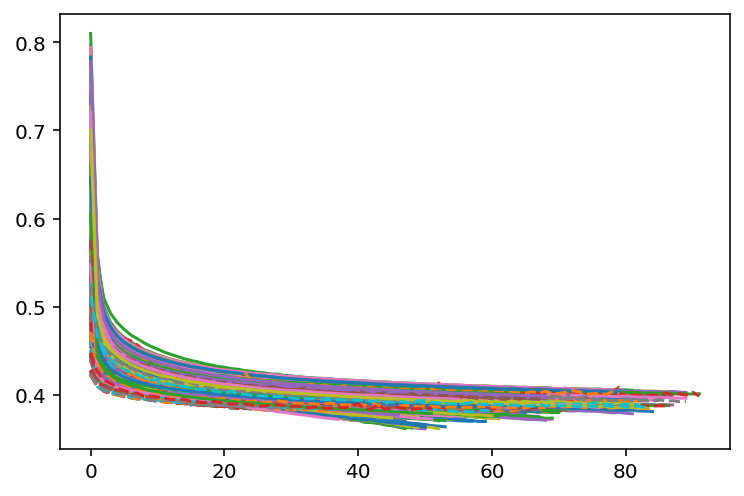

In [11]:
min_i, min_v, max_i, max_v = min_max(df)

rap_input_dims rap_output_dims rtma_input_channels  \
118   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
119   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   

          goes_input_channels n_rap_inputs n_im_inputs     hiddens  \
118  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)  [512, 256]   
119  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)  [512, 256]   

     n_network_outputs   n_units_in_conv_layers kernels_size_and_stride  \
118                512  [32, 64, 128, 256, 256]                  (3, 1)   
119                512  [32, 64, 128, 256, 256]                  (3, 1)   

    rap_activation dense_activation optim      lr loss_f  n_epochs  \
118           relu             relu  adam  0.0001    MSE       100   
119           relu             relu  adam  0.0001    MSE       100   

     batch_size  batchnorm  dropout  \
118         128      False    False   
119         128      False     True   

                                                  loss  \
118  [0.4372572600841522, 0.21649466454982758, 0.19...   
119  [0.574141263961792, 0.3252117931842804, 0.2777...   

                               root_mean_squared_error  \
118  [0.6612542867660522, 0.4652898609638214, 0.441...   
119  [0.7577211260795593, 0.5702734589576721, 0.526...   

                                    mean_squared_error  \
118  [0.4372572600841522, 0.21649466454982758, 0.19...   
119  [0.574141263961792, 0.3252117931842804, 0.2777...   

                                   mean_absolute_error  \
118  [0.4822936952114105, 0.3200552761554718, 0.297...   
119  [0.5780319571495056, 0.4239158034324646, 0.385...   

                                              val_loss  \
118  [0.23196110129356384, 0.20042243599891663, 0.1...   
119  [0.2982834279537201, 0.23243917524814606, 0.21...   

                           val_root_mean_squared_error  \
118  [0.48162341117858887, 0.4476856589317322, 0.42...   
119  [0.5461533069610596, 0.48211947083473206, 0.46...   

                                val_mean_squared_error  \
118  [0.23196110129356384, 0.20042243599891663, 0.1...   
119  [0.2982834279537201, 0.23243917524814606, 0.21...   

                               val_mean_absolute_error  \
118  [0.341557115316391, 0.3063412010669708, 0.2891...   
119  [0.4044734239578247, 0.3420489728450775, 0.323...   

                             ml_temperature_train_rmse  \
118  [1.2626653645458357, 1.1807850229761765, 1.277...   
119  [2.7460640232685796, 2.179025999214226, 1.9929...   

     ml_temperature_train_mean_rmse  \
118                        1.036566   
119                        1.209267   

                         ml_temperature_train_rmse_sfc  \
118  [1.2626653645458357, 1.1807850229761765, 1.277...   
119  [2.7460640232685796, 2.179025999214226, 1.9929...   

     ml_temperature_train_mean_rmse_sfc  \
118                            1.211785   
119                            1.680039   

                                ml_dewpoint_train_rmse  \
118  [1.3781639100190344, 1.4633529210438692, 1.520...   
119  [2.0917004601178704, 2.0614875674343205, 2.062...   

     ml_dewpoint_train_mean_rmse  \
118                     3.935008   
119                     4.105163   

                            ml_dewpoint_train_rmse_sfc  \
118  [1.3781639100190344, 1.4633529210438692, 1.520...   
119  [2.0917004601178704, 2.0614875674343205, 2.062...   

     ml_dewpoint_train_mean_rmse_sfc  \
118                         2.915663   
119                         3.172872   

                               ml_temperature_val_rmse  \
118  [1.3247314508501096, 1.2054663550852613, 1.288...   
119  [2.7734489045611705, 2.2161783204083343, 2.057...   

     ml_temperature_val_mean_rmse  \
118                      1.066948   
119                      1.259486   

                           ml_temperature_val_rmse_sfc  \
118  [1.3247314508501096, 1.2054663550852613, 1.288...   
119  [2.7734489045611705, 2.2161783204083343, 2.057...   

     ml_temperature_val

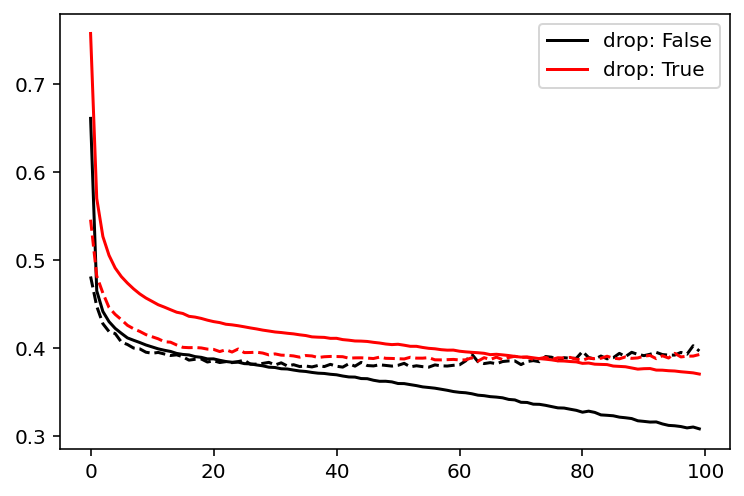

In [21]:
# get same models following first 16 params
filtered_df = df
for k, v in zip(df.iloc[min_i][:17].keys(), df.iloc[min_i][:17].values):
    filtered_df = filtered_df[filtered_df[k] == v]
    
#######

plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'root_mean_squared_error'])), color='k',
         label=f"drop: {filtered_df.iloc[0]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'val_root_mean_squared_error'])), '--k')

plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'root_mean_squared_error'])), color='r',
         label=f"drop: {filtered_df.iloc[1]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'val_root_mean_squared_error'])), '--r')

plt.legend()
filtered_df

# UNet

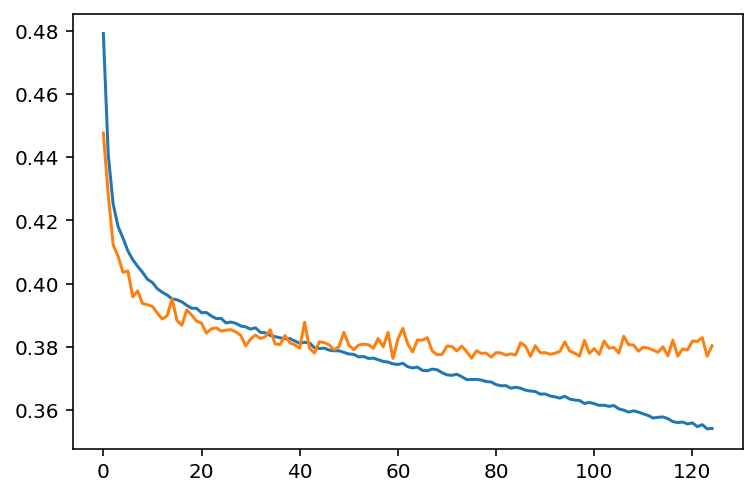

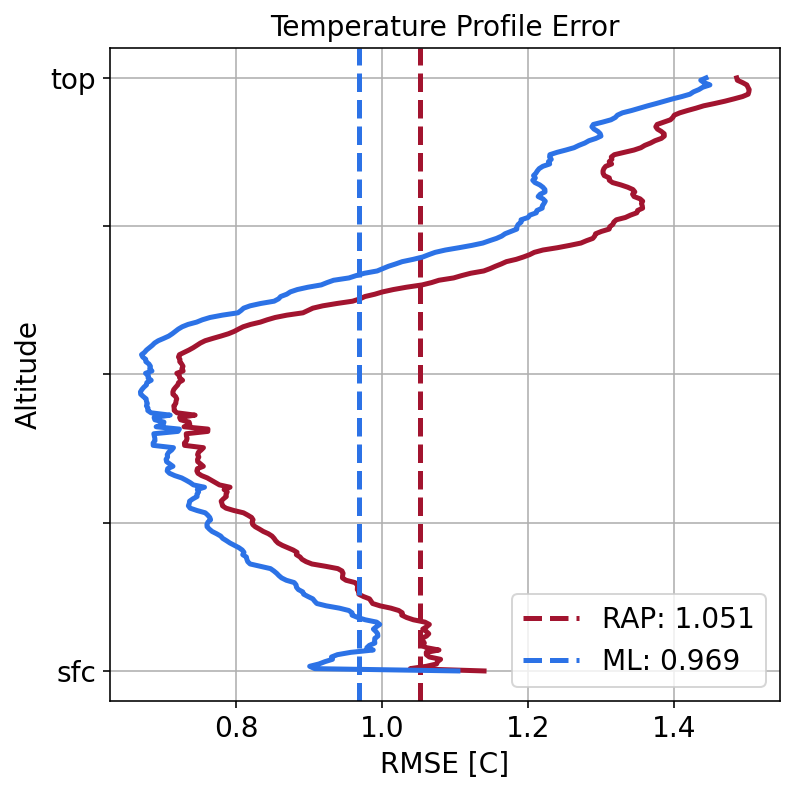

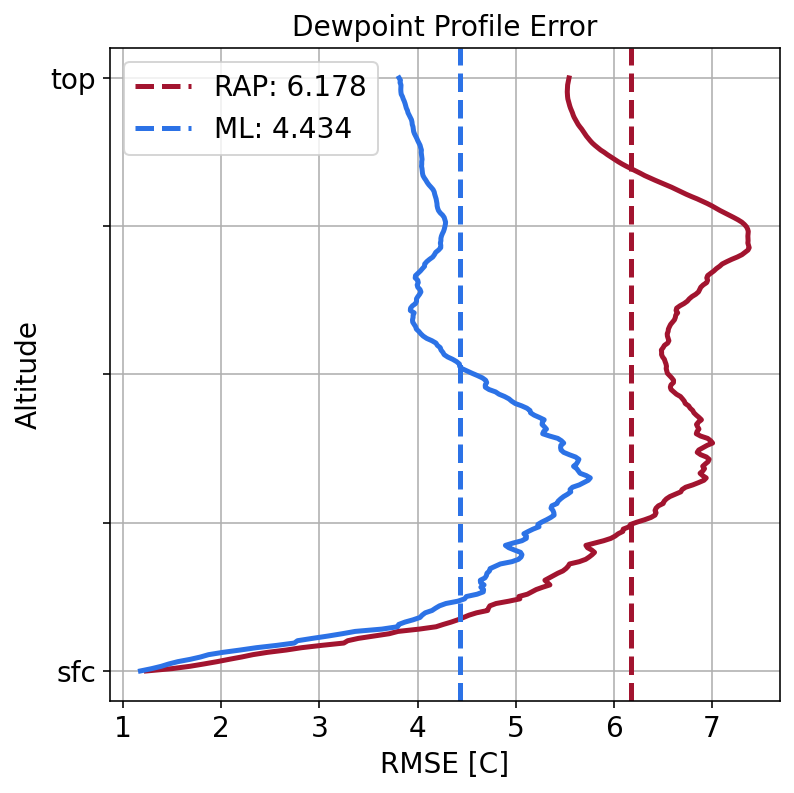

In [34]:
df = pd.read_csv(os.path.join(VOL, 'alley_skip_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse_sfc']).index[0]
fig, ax = plt.subplots()
data_set = 'test' # 'train'
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_{data_set}_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse, title=f'{v.capitalize()} Profile Error',
                                               file_name=f'/home/stock/research/media/unet_{v}_{data_set}.png')

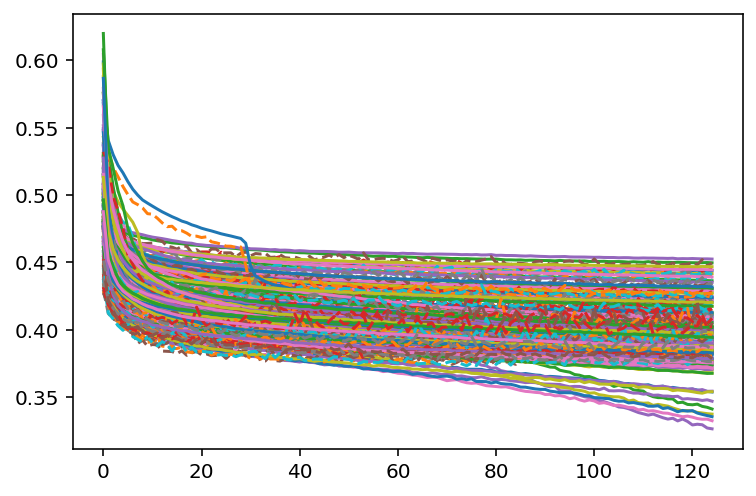

In [23]:
min_i, min_v, max_i, max_v = min_max(df)

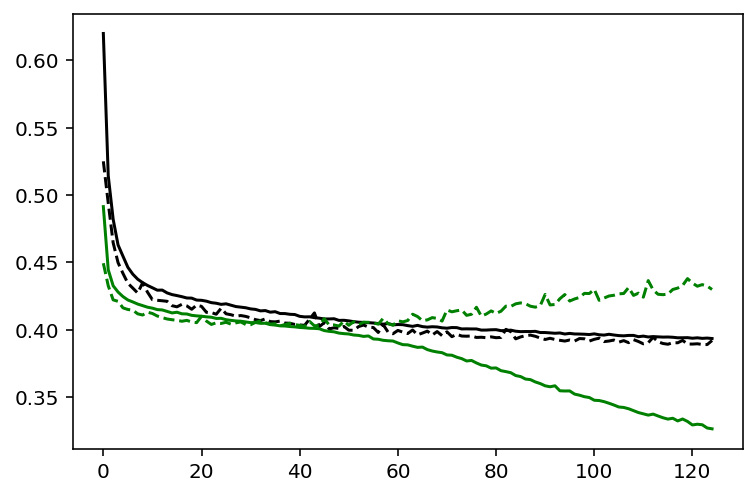

In [24]:
i = max_i
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'k')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--k')

i = min_i
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'g')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--g')

In [25]:
df.iloc[min_i] 

rap_input_dims                                                             [0, 1, 2, 3]
rap_output_dims                                                                  [1, 2]
rtma_input_channels                                                                  []
goes_input_channels                                                                  []
n_rap_inputs                                                                   (256, 4)
n_im_inputs                                                                         NaN
hiddens                                                                              []
n_network_outputs                                                                   512
n_units_in_conv_layers                                               [32, 64, 128, 256]
kernels_size_and_stride                                                          (3, 1)
rap_activation                                                                     relu
dense_activation                

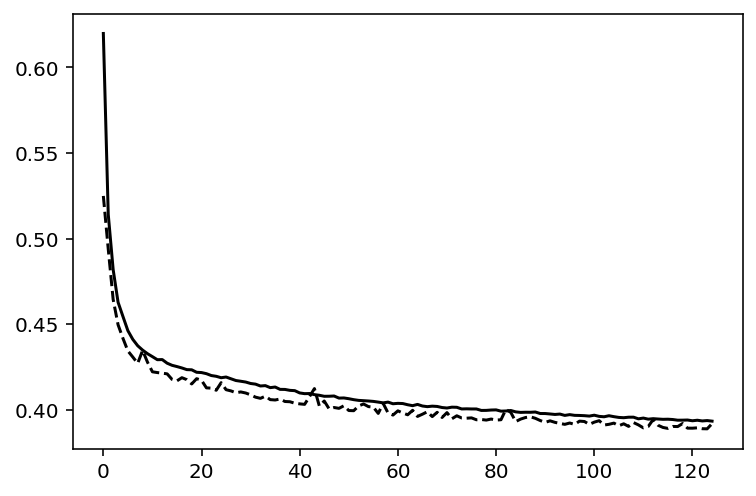

In [26]:
i = max_i
plt.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])), 'k')
plt.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])), '--k')

In [27]:
df[df['dropout'] == True].sort_values(['ml_temperature_test_mean_rmse']).head()

rap_input_dims rap_output_dims rtma_input_channels  \
51    [0, 1, 2, 3]          [1, 2]                  []   
123   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
87    [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
15    [0, 1, 2, 3]          [1, 2]                  []   
105   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   

          goes_input_channels n_rap_inputs n_im_inputs hiddens  \
51   [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (3, 3, 8)      []   
123  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)      []   
87                         []     (256, 4)   (3, 3, 3)      []   
15                         []     (256, 4)         NaN      []   
105                        []     (256, 4)   (3, 3, 3)      []   

     n_network_outputs n_units_in_conv_layers kernels_size_and_stride  \
51                 512     [32, 64, 128, 256]                  (3, 1)   
123                512     [32, 64, 128, 256]                  (3, 1)   
87                 512     [32, 64, 128, 256]                  (3, 1)   
15                 512     [32, 64, 128, 256]                  (3, 1)   
105                512              [64, 128]                  (3, 1)   

    rap_activation dense_activation optim      lr loss_f  n_epochs  \
51            relu             relu  adam  0.0001    MAE       125   
123           relu             relu  adam  0.0001    MAE       125   
87            relu             relu  adam  0.0001    MAE       125   
15            relu             relu  adam  0.0001    MAE       125   
105           relu             relu  adam  0.0001    MAE       125   

     batch_size  batchnorm  dropout  \
51          128      False     True   
123         128      False     True   
87          128      False     True   
15          128      False     True   
105         128      False     True   

                                                  loss  \
51   [0.3027131259441376, 0.27594390511512756, 0.26...   
123  [0.2986166477203369, 0.2732030153274536, 0.265...   
87   [0.31787052750587463, 0.28560182452201843, 0.2...   
15   [0.31770578026771545, 0.28425395488739014, 0.2...   
105  [0.2944723665714264, 0.27286744117736816, 0.26...   

                               root_mean_squared_error  \
51   [0.49590831995010376, 0.45052218437194824, 0.4...   
123  [0.4881390929222107, 0.4458632469177246, 0.433...   
87   [0.5171539783477783, 0.4719376862049103, 0.451...   
15   [0.5153647661209106, 0.47108742594718933, 0.45...   
105  [0.4978128969669342, 0.46415063738822937, 0.45...   

                                    mean_squared_error  \
51   [0.24592505395412445, 0.2029702365398407, 0.19...   
123  [0.23827975988388062, 0.19879403710365295, 0.1...   
87   [0.2674482464790344, 0.22272516787052155, 0.20...   
15   [0.2656008303165436, 0.221923366189003, 0.2040...   
105  [0.24781769514083862, 0.21543580293655396, 0.2...   

                                   mean_absolute_error  \
51   [0.28687354922294617, 0.26213112473487854, 0.2...   
123  [0.28259485960006714, 0.25894466042518616, 0.2...   
87   [0.301939457654953, 0.2721324861049652, 0.2614...   
15   [0.30224815011024475, 0.27138853073120117, 0.2...   
105  [0.2876015603542328, 0.2663021981716156, 0.260...   

                                              val_loss  \
51   [0.2774202525615692, 0.26604244112968445, 0.26...   
123  [0.2734498679637909, 0.2619951069355011, 0.258...   
87   [0.2919590175151825, 0.27362892031669617, 0.26...   
15   [0.2887329161167145, 0.27200353145599365, 0.26...   
105  [0.2776646018028259, 0.2656036913394928, 0.262...   

                           val_root_mean_squared_error  \
51   [0.45589059591293335, 0.4350384771823883, 0.42...   
123  [0.44697636365890503, 0.42413192987442017, 0.4...   
87   [0.4825233817100525, 0.4494277834892273, 0.433...   
15   [0.48078715801239014, 0.4499697983264923, 0.44...   
105  [0.47329244017601013, 0.45128101110458374, 0.4...   

                                val_mean_squared_error  \
51   [0.207

In [28]:
df.sort_values(['ml_temperature_test_mean_rmse']).head()

rap_input_dims rap_output_dims rtma_input_channels  \
122   [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
50    [0, 1, 2, 3]          [1, 2]                  []   
86    [0, 1, 2, 3]          [1, 2]           [0, 1, 2]   
14    [0, 1, 2, 3]          [1, 2]                  []   
52    [0, 1, 2, 3]          [1, 2]                  []   

          goes_input_channels n_rap_inputs n_im_inputs hiddens  \
122  [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)  (3, 3, 11)      []   
50   [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (3, 3, 8)      []   
86                         []     (256, 4)   (3, 3, 3)      []   
14                         []     (256, 4)         NaN      []   
52   [0, 1, 2, 3, 4, 5, 6, 7]     (256, 4)   (3, 3, 8)      []   

     n_network_outputs n_units_in_conv_layers kernels_size_and_stride  \
122                512     [32, 64, 128, 256]                  (3, 1)   
50                 512     [32, 64, 128, 256]                  (3, 1)   
86                 512     [32, 64, 128, 256]                  (3, 1)   
14                 512     [32, 64, 128, 256]                  (3, 1)   
52                 512     [32, 64, 128, 256]                  (3, 1)   

    rap_activation dense_activation optim      lr loss_f  n_epochs  \
122           relu             relu  adam  0.0001    MAE       125   
50            relu             relu  adam  0.0001    MAE       125   
86            relu             relu  adam  0.0001    MAE       125   
14            relu             relu  adam  0.0001    MAE       125   
52            relu             relu  adam  0.0001  Huber       125   

     batch_size  batchnorm  dropout  \
122         128      False    False   
50          128      False    False   
86          128      False    False   
14          128      False    False   
52          128      False    False   

                                                  loss  \
122  [0.2913960814476013, 0.2695964276790619, 0.260...   
50   [0.2923714220523834, 0.2679113745689392, 0.260...   
86   [0.3001312017440796, 0.27471303939819336, 0.26...   
14   [0.3040180206298828, 0.27778059244155884, 0.26...   
52   [0.11161691695451736, 0.09613002836704254, 0.0...   

                               root_mean_squared_error  \
122  [0.47909998893737793, 0.4407629668712616, 0.42...   
50   [0.4809386134147644, 0.43494367599487305, 0.42...   
86   [0.49760666489601135, 0.4536258578300476, 0.43...   
14   [0.49984467029571533, 0.4602358937263489, 0.44...   
52   [0.47489362955093384, 0.43335065245628357, 0.4...   

                                    mean_squared_error  \
122  [0.22953678667545319, 0.194271981716156, 0.180...   
50   [0.23130196332931519, 0.18917600810527802, 0.1...   
86   [0.24761240184307098, 0.2057764083147049, 0.18...   
14   [0.24984470009803772, 0.21181705594062805, 0.1...   
52   [0.2255239635705948, 0.18779277801513672, 0.17...   

                                   mean_absolute_error  \
122  [0.27529358863830566, 0.2552758455276489, 0.24...   
50   [0.276581734418869, 0.2538857161998749, 0.2469...   
86   [0.2844202518463135, 0.26124298572540283, 0.25...   
14   [0.28861504793167114, 0.26484569907188416, 0.2...   
52   [0.2790272831916809, 0.2575819790363312, 0.250...   

                                              val_loss  \
122  [0.2757836878299713, 0.26426252722740173, 0.25...   
50   [0.2736697196960449, 0.2618383467197418, 0.254...   
86   [0.2883766293525696, 0.26474255323410034, 0.26...   
14   [0.2851107716560364, 0.2762897312641144, 0.261...   
52   [0.09872845560312271, 0.09473296999931335, 0.0...   

                           val_root_mean_squared_error  \
122  [0.4476132392883301, 0.42815515398979187, 0.41...   
50   [0.4428524971008301, 0.42269301414489746, 0.41...   
86   [0.4730848968029022, 0.4338998794555664, 0.425...   
14   [0.4693380296230316, 0.44821229577064514, 0.42...   
52   [0.43753913044929504, 0.4242347180843353, 0.40...   

                                val_mean_squared_error  \
122  [0.200

# Best Model

In [6]:
from soundings.experiments import cnn_skip_neuralnetwork_driver as cnndriver

from soundings.deep_learning import tf_neuralnetwork as nn

In [7]:
data = (RAPtrain , RAPval,  RAPtest, 
        RTMAtrain, RTMAval, RTMAtest,
        GOEStrain, GOESval, GOEStest,
        RAOBtrain, RAOBval, RAOBtest)
rap_input_dims = [0, 1, 2, 3]
rap_output_dims = [1, 2]
rtma_input_channels = [0, 1, 2]
goes_input_channels = [0, 1, 2, 3, 4, 5, 6, 7]

driver = cnndriver.CNNSkipNetworkDriver()

Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = driver.organize_data(data, rap_input_dims, rap_output_dims,
                                                                rtma_input_channels, goes_input_channels)

INFO: data organization - [0, 1, 2, 3] [1, 2] [0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
INFO: data dimensions - (28782, 256, 4) (28782, 3, 3, 11) (28782, 512) (3840, 256, 4) (3840, 3, 3, 11) (3840, 512) (5733, 256, 4) (5733, 3, 3, 11) (5733, 512)


In [25]:
# i = 8
# Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = Xtr[:,::i], Xti, Tt[:,::i], Xvr[:,::i], Xvi, Tv[:,::i], Xer[:,::i], Xei, Te[:,::i]

In [8]:
n_hiddens_list = []
n_units_in_conv_layers = [32, 64, 128, 256]
kernels_size_and_stride = '(3, 1)'
rap_activation = 'relu'
dense_activation = ''
optim = 'adam'
lr = 0.0001
loss = 'MAE'
n_epochs = 125
batch_size = 128
dropout = False
batchnorm = False

n_rap_inputs = Xtr.shape[1:] # (256, 4)
n_im_inputs  = Xti.shape[1:] if Xti is not None else None # (3, 3, 3)
n_network_outputs = Tt.shape[1]

nnet = nn.SkipNeuralNetwork(n_rap_inputs, n_im_inputs, n_hiddens_list, n_units_in_conv_layers,
                            [literal_eval(kernels_size_and_stride)]* \
                                len(n_units_in_conv_layers), # all same size
                            n_network_outputs, rap_activation=rap_activation,
                            dense_activation=dense_activation, 
                            batchnorm=batchnorm, dropout=dropout)
nnet.model.summary()
nnet.train(Xtr, Xti, Tt, n_epochs, batch_size, method=optim, verbose=True,
           learning_rate=lr, validation=(Xvr, Xvi, Tv), loss_f=loss)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rap (InputLayer)                [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 32)      416         rap[0][0]                        
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 32)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
skip_conv1d_0 (Conv1D)          (None, 256, 32)      3104        activation[0][0]                 
_______________________________________________________________________________________

epoch: 0, rmse 0.48549, val_rmse 0.43847
epoch: 25, rmse 0.39598, val_rmse 0.39145
epoch: 50, rmse 0.38065, val_rmse 0.39090
epoch: 75, rmse 0.36975, val_rmse 0.38133
epoch: 100, rmse 0.35923, val_rmse 0.38093
epoch: 124, rmse 0.34891, val_rmse 0.38615
finished!


SkipNeuralNetwork(512)
  Final objective value is 0.21290 in 403.5686 seconds.

## Standard Metrics

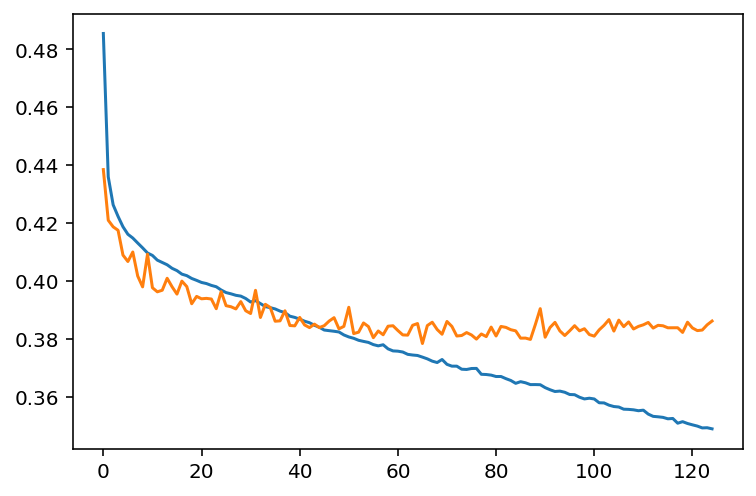

In [10]:
fig, ax = plt.subplots()
ax.plot(nnet.history[f'root_mean_squared_error'])
ax.plot(nnet.history[f'val_root_mean_squared_error'])

In [14]:
r = dict()

TEMP, DEWPT = 0, 1
sets = ['train', 'val', 'test']

for j, (Xr, Xi, RAP, T) in enumerate([(Xtr, Xti, RAPtrain, RAOBtrain),
                                      (Xvr, Xvi, RAPval  , RAOBval),
                                      (Xer, Xei, RAPtest , RAOBtest)]):

    X = {'rap': Xr, 'im': Xi} if Xi is not None else {'rap': Xr}
    Y = nnet.use(X).reshape(RAP[:,:,rap_output_dims].shape) # (None, 256, N)

    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,TEMP], T[:, :, 1])
    r[f'ml_temperature_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,DEWPT], T[:, :, 2])
    r[f'ml_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

In [15]:
df = pd.DataFrame([r])

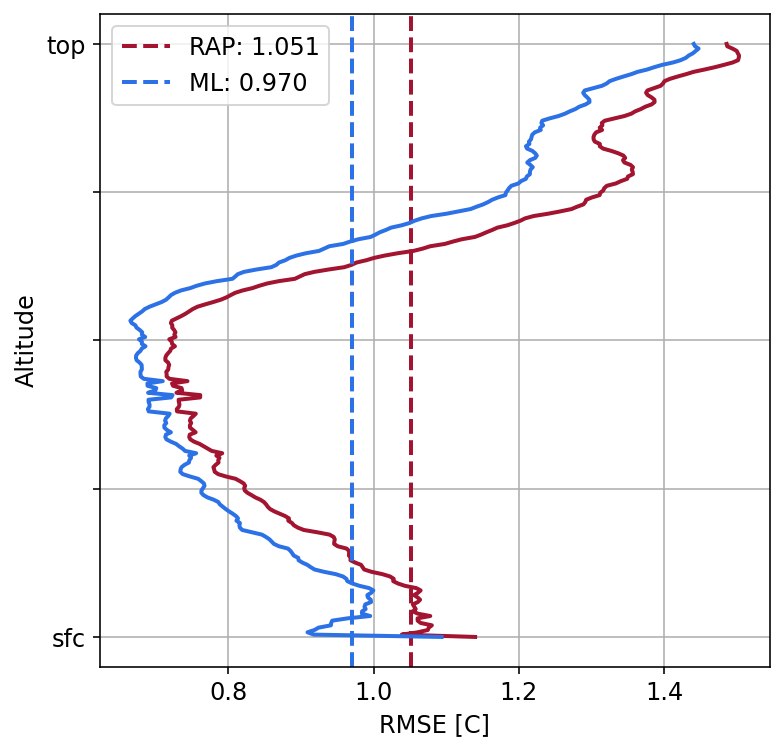

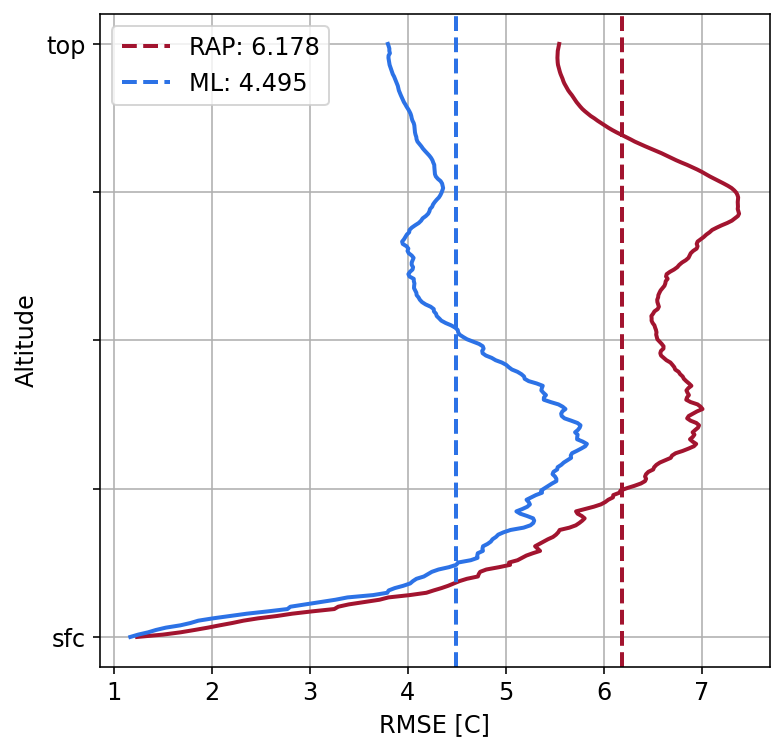

In [16]:
i = 0
data_set = 'test' # 'train'
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(df.iloc[i][f'ml_{v}_{data_set}_rmse'])
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

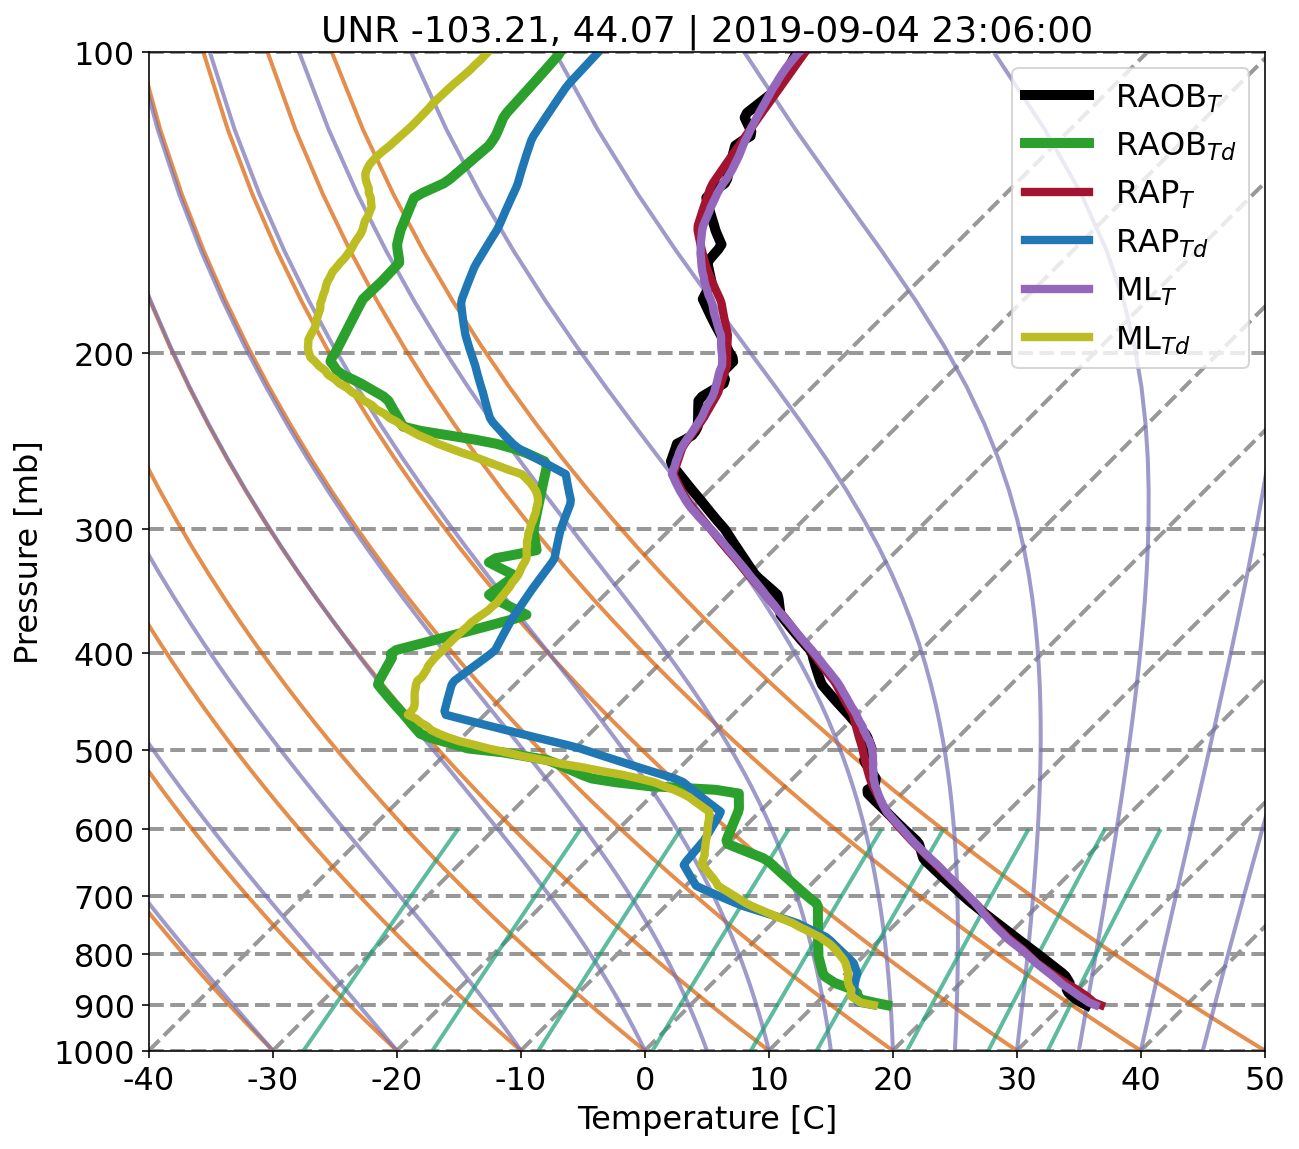

In [16]:
index = 1 # 1126
X = {'rap': Xer[index:index+1], 'im': Xei[index:index+1]} if Xei is not None else {'rap': Xer[index:index+1]}
Y = nnet.use(X).reshape(RAP[0:1,:,rap_output_dims].shape)

sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = Y[0,:,0]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = RAOBtest[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = RAPtest[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.PREDICTED_DEWPOINT_COLUMN_KEY] = Y[0,:,1]

content = FILEtest[index].split('_')
date = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f')
lon, lat = content[-2], content[-1]
title = f'{content[0].upper()} {lon}, {lat} | {date}'
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title,
                                         file_name=f"/home/stock/research/media/{content[0]}-{content[1]}_unet_upperair.pdf");

## Cloud Mask

In [17]:
bcm = np.load('/mnt/data1/stock/mlsoundings/goes_bcm_alley.npy')
bcm[np.isnan(bcm)] = -1 # nans to zero

In [18]:
bcm.shape

(38373, 1, 128, 128)

In [19]:
center = bcm.shape[-2]//2
new_size = 16
bcm = bcm[:,:,center-new_size//2:center+new_size//2, center-new_size//2:center+new_size//2]
bcm.shape

(38373, 1, 16, 16)

In [20]:
cloudy = np.zeros(len(bcm))
np.seterr(all='raise')
# 0 = clear or probably clear and 1 = cloudy or probably cloudy.
total = bcm.shape[-2] * bcm.shape[-1]
for i in range(len(bcm)):
    try:
        if (bcm[i] == -1).any(): # invalid
            cloudy[i] = -1
        elif ((bcm[i] == 1).sum() / total) >= .85: # 75% are cloudy
            cloudy[i] = 1
    except Exception as e:
        print(i,e)
np.unique(cloudy, return_counts=True)

(array([-1.,  0.,  1.]), array([ 2638, 20982, 14753]))

In [21]:
CLOUDtrain, CLOUDval, CLOUDtest = cloudy[train_i], cloudy[val_i], cloudy[test_i]

In [22]:
np.unique(CLOUDtest, return_counts=True)

(array([-1.,  0.,  1.]), array([ 392, 3096, 2245]))

In [16]:
np.unique(CLOUDtest, return_counts=True)

(array([-1.,  0.,  1.]), array([ 392, 3247, 2094]))

In [72]:
r = dict()

TEMP, DEWPT = 0, 1
sets = ['test']

for j, (Xr, Xi, RAP, T, cloud) in enumerate([(Xer, Xei, RAPtest , RAOBtest, CLOUDtest)]):

    X = {'rap': Xr, 'im': Xi} if Xi is not None else {'rap': Xr}
    Y = nnet.use(X).reshape(RAP[:,:,rap_output_dims].shape) # (None, 256, N)
    print('evaluating!')
    for c in np.unique(cloud):
        Yc = Y[cloud==c]
        Tc = T[cloud==c]
        Rc = RAP[cloud==c]
        (rmse, mean_rmse, # temperature
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Yc[:,:,TEMP], Tc[:, :, 1])
        r[f'ml_{c}_temperature_{sets[j]}_rmse'] = rmse.tolist()
        r[f'ml_{c}_temperature_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'ml_{c}_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'ml_{c}_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

        (rmse, mean_rmse, # dewpoint
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Yc[:,:,DEWPT], Tc[:, :, 2])
        r[f'ml_{c}_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
        r[f'ml_{c}_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'ml_{c}_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'ml_{c}_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc
        
        (rmse, mean_rmse, # temperature
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Rc[:,:,1], Tc[:, :, 1])
        r[f'rap_{c}_temperature_{sets[j]}_rmse'] = rmse.tolist()
        r[f'rap_{c}_temperature_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'rap_{c}_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'rap_{c}_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

        (rmse, mean_rmse, #dewpoint
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Rc[:,:,2], Tc[:, :, 2])
        r[f'rap_{c}_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
        r[f'rap_{c}_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'rap_{c}_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'rap_{c}_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

evaluating!


In [76]:
df = pd.DataFrame([r])
# df.to_csv('/mnt/data1/stock/mlsoundings/results/unet_cloud_performance.csv', index=False)

In [77]:
df.filter(regex='mean')

ml_-1.0_temperature_test_mean_rmse  ml_-1.0_temperature_test_mean_rmse_sfc  \
0                            1.023428                                1.047438   

   ml_-1.0_dewpoint_test_mean_rmse  ml_-1.0_dewpoint_test_mean_rmse_sfc  \
0                         4.631937                              3.12751   

   rap_-1.0_temperature_test_mean_rmse  \
0                             1.133822   

   rap_-1.0_temperature_test_mean_rmse_sfc  rap_-1.0_dewpoint_test_mean_rmse  \
0                                  1.14309                          6.783251   

   rap_-1.0_dewpoint_test_mean_rmse_sfc  ml_0.0_temperature_test_mean_rmse  \
0                              3.593056                           0.904029   

   ml_0.0_temperature_test_mean_rmse_sfc  ml_0.0_dewpoint_test_mean_rmse  \
0                               0.896075                        4.279388   

   ml_0.0_dewpoint_test_mean_rmse_sfc  rap_0.0_temperature_test_mean_rmse  \
0                            2.919083                            0.976353   

   rap_0.0_temperature_test_mean_rmse_sfc  rap_0.0_dewpoint_test_mean_rmse  \
0                                0.993001                         6.372542   

   rap_0.0_dewpoint_test_mean_rmse_sfc  ml_1.0_temperature_test_mean_rmse  \
0                             3.302178                           1.051701   

   ml_1.0_temperature_test_mean_rmse_sfc  ml_1.0_dewpoint_test_mean_rmse  \
0                               1.072251                        4.595023   

   ml_1.0_dewpoint_test_mean_rmse_sfc  rap_1.0_temperature_test_mean_rmse  \
0                            2.682864                            1.143763   

   rap_1.0_temperature_test_mean_rmse_sfc  rap_1.0_dewpoint_test_mean_rmse  \
0                                1.146168                         5.737781   

   rap_1.0_dewpoint_test_mean_rmse_sfc  
0                             3.078673

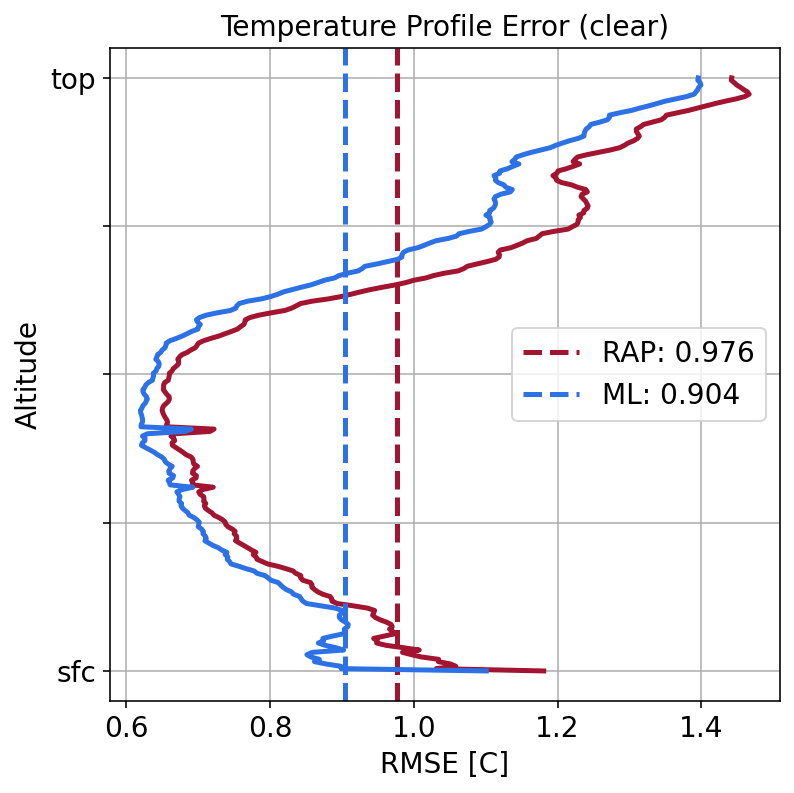

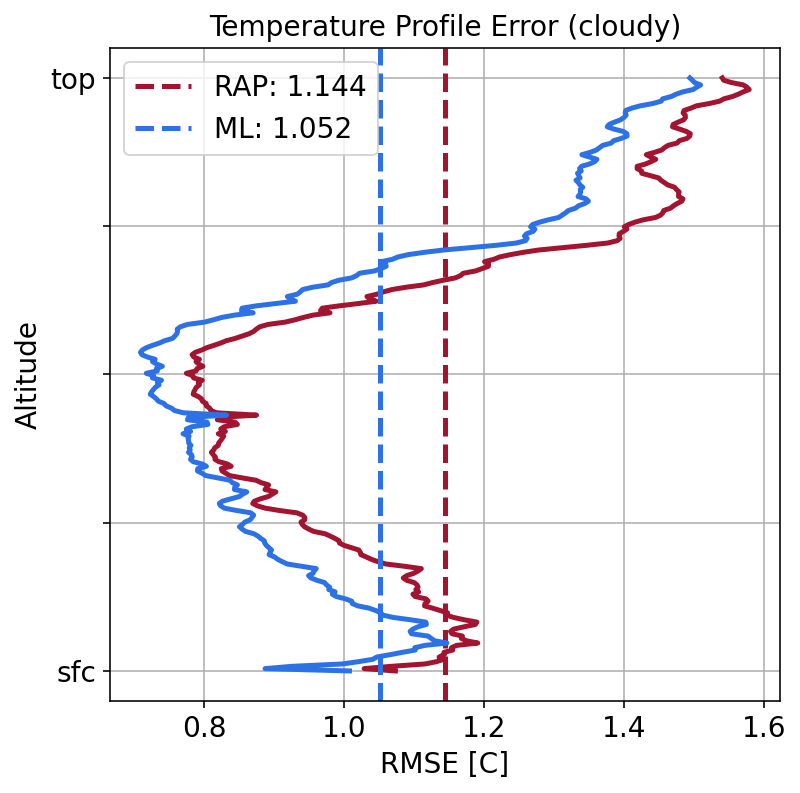

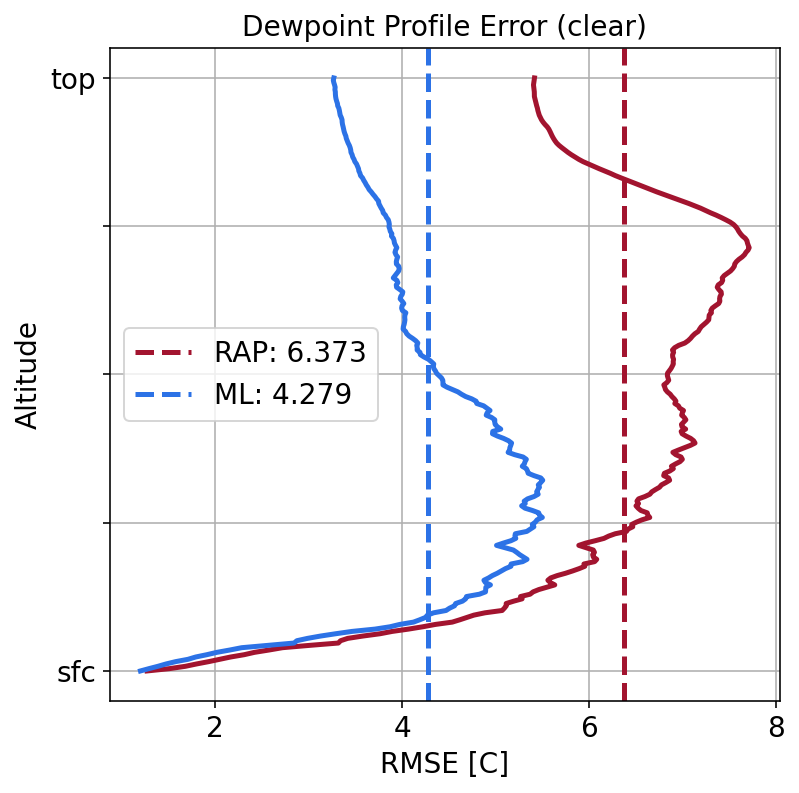

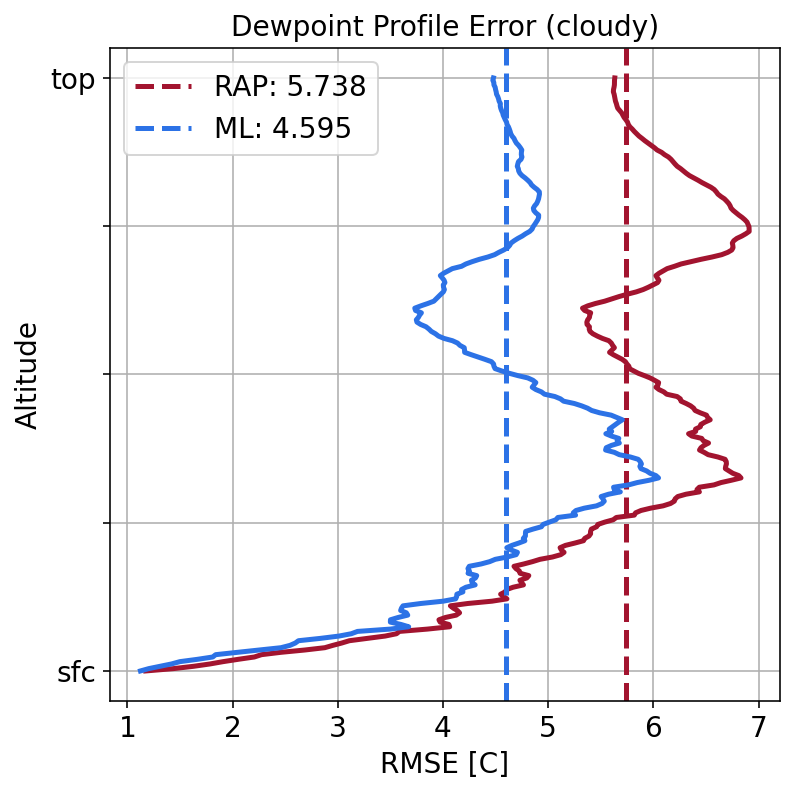

In [75]:
i = 0
data_set = 'test' # 'train'
for v in ['temperature', 'dewpoint']:
    for c in ([0.0, 1.0]):
        label = ('clear', 'cloudy')[int(c)]
        ml_rmse = np.asarray(df.iloc[i][f'ml_{c}_{v}_{data_set}_rmse'])
        ml_mean_rmse = df.iloc[i][f'ml_{c}_{v}_{data_set}_mean_rmse']
        rap_rmse = np.asarray(df.iloc[i][f'rap_{c}_{v}_{data_set}_rmse'])
        rap_mean_rmse = df.iloc[i][f'rap_{c}_{v}_{data_set}_mean_rmse']

        results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse, 
                                                   title=f'{v.capitalize()} Profile Error ({label})',
                                                   file_name=f'/home/stock/research/media/unet_cloud_mask_{label}_{v}_{data_set}.png')

## Regional Errors

In [17]:
names_train = [f.split('_')[0] for f in FILEtrain]
names_val   = [f.split('_')[0] for f in FILEval]
names_test  = [f.split('_')[0] for f in FILEtest]

In [18]:
np.unique(np.hstack([names_train, names_val, names_test]), return_counts=True)

(array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
        'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
       dtype='<U3'),
 array([2206, 2145, 2129, 2129, 1421, 2186, 2223, 2220, 2122, 2271, 2045,
        2193, 2116, 2142, 2259, 2257, 2139, 2152]))

In [75]:
locations = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    t = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        arr = locations[name][2]
        arr.append(i)
        locations[name] = (lon, lat, arr)
    else:
        locations[name] = (lon, lat, [i])
        
df = pd.DataFrame.from_dict(locations).T
df = df.reset_index()
df.columns = ['location', 'lon', 'lat', 'indicies']
df.head(5)

location      lon    lat                                           indicies
0      lbf  -100.68  41.13  [0, 62, 65, 99, 110, 135, 142, 153, 157, 159, ...
1      unr  -103.21  44.07  [1, 15, 25, 33, 77, 101, 104, 169, 293, 295, 3...
2      lzk   -92.27  34.83  [2, 3, 6, 17, 19, 23, 44, 46, 47, 51, 59, 79, ...
3      sgf    -93.4  37.23  [4, 12, 16, 32, 117, 125, 126, 151, 165, 197, ...
4      fwd    -97.3   32.8  [5, 48, 67, 113, 114, 120, 136, 164, 171, 173,...

In [76]:
t_rmse  = []
td_rmse = []
og_t_rmse  = []
og_td_rmse = []
n_samples = []

X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    T_loc = T[inds]
    Y_loc = Y[inds]
    t_rmse.append(ml.rmse(T_loc[:,:,1], Y_loc[:,:,0]))
    td_rmse.append(ml.rmse(T_loc[:,:,2], Y_loc[:,:,1]))
    og_t_rmse.append(ml.rmse(T_loc[:,:,1], RAPtest[inds,:,1]))
    og_td_rmse.append(ml.rmse(T_loc[:,:,2], RAPtest[inds,:,2]))
    n_samples.append(len(inds))

df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse
df['og_t_rmse'] = og_t_rmse
df['og_td_rmse'] = og_td_rmse
df['n_samples'] = n_samples

In [73]:
percent_change(100, 10)

-90.0

In [77]:
def percent_change(start, final):
    return -100 * (start - final)/abs(start)

df['t_change']  = percent_change(df['og_t_rmse'],df['t_rmse'])
df['td_change'] = percent_change(df['og_td_rmse'],df['td_rmse'])

In [78]:
df.head(5)

location      lon    lat                                           indicies  \
0      lbf  -100.68  41.13  [0, 62, 65, 99, 110, 135, 142, 153, 157, 159, ...   
1      unr  -103.21  44.07  [1, 15, 25, 33, 77, 101, 104, 169, 293, 295, 3...   
2      lzk   -92.27  34.83  [2, 3, 6, 17, 19, 23, 44, 46, 47, 51, 59, 79, ...   
3      sgf    -93.4  37.23  [4, 12, 16, 32, 117, 125, 126, 151, 165, 197, ...   
4      fwd    -97.3   32.8  [5, 48, 67, 113, 114, 120, 136, 164, 171, 173,...   

     t_rmse   td_rmse  og_t_rmse  og_td_rmse  n_samples   t_change  td_change  
0  1.072719  4.314196   1.147094    6.039947        317  -6.483724 -28.572286  
1  1.112612  4.619203   1.234327    6.184986        321  -9.860834 -25.315868  
2  0.921241  4.740779   1.090822    6.755720        340 -15.546189 -29.825711  
3  0.903104  3.734250   0.992488    4.903295        336  -9.006001 -23.842012  
4  0.889323  4.506653   0.943972    6.544340        332  -5.789281 -31.136627

In [40]:
def regional_error_map(df, count, title, colorscale='ylorbr_r', fig_title='', colorbar_title=''):
    fig = go.Figure(data=go.Scattergeo(
            locationmode = 'USA-states',
            lon = df['lon'],
            lat = df['lat'],
            text = df['location'],
            mode = 'markers',
            marker = dict(
                size = 6,
                opacity = 0.80,
                reversescale = True,
                autocolorscale = False,
                symbol = 'square',
                line = dict(
                    width=0.80,
                    color='rgba(75, 75, 75)'
                ),
                colorscale = colorscale, # rdgy, viridis
                cmin = df[count].min(), # 0,
                color = df[count],
                cmax = df[count].max(),
                colorbar = dict(
                    title = dict(side= 'right', text=colorbar_title),
                    titlefont = dict(color='black', size=11),
                    nticks = 10,
                    len = 0.90,
                    thickness = 10,
                    ticks = 'outside',
                    tickcolor = 'black',
                    tickfont = dict(family='Arial', size=11, color='black'), # "Courier New", "Times New Roman"
                    x = 0.90
                ),
            )
                   ))
    """
    ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
     'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
     'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
     'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
     'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
     'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
     'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
     'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
     'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
     'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
     'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
     'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
     'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
     'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']
    """
    fig.update_layout(
            geo = dict(
                scope = 'usa',
                projection_type = 'albers usa',
                showland = True,
                landcolor = "rgb(250, 250, 250)",
                subunitcolor = "rgb(100, 100, 100)",
                countrycolor = "rgb(100, 100, 100)",
                countrywidth = 0.5,
                subunitwidth = 0.5
            ), 
            title_text = fig_title,
            title_x=0.5,
            title_y=1,
            title_font_color='black',
            title_font_size=11,
            margin=dict(l=0, r=0, t=0, b=5)
        )
    fig.show()

    fig.write_image(title, width=450, height=225, scale=4)

In [41]:
locations = dict()

for i, f in enumerate(np.hstack([FILEtrain,FILEval,FILEtest])):
    content = f.split('_')
    t = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        arr = locations[name][2]
        arr.append(i)
        locations[name] = (lon, lat, arr)
    else:
        locations[name] = (lon, lat, [i])
        
df_samples = pd.DataFrame.from_dict(locations).T
df_samples = df_samples.reset_index()
df_samples.columns = ['location', 'lon', 'lat', 'indicies']

n_samples = []

for i in range(len(df_samples)):
    inds = df_samples.iloc[i]['indicies']
    n_samples.append(len(inds))

df_samples['n_samples'] = n_samples

In [37]:
"""
['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
 'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
 'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
 'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
 'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
 'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
 'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
 'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
 'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
 'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']
"""

"\n['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',\n 'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',\n 'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',\n 'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',\n 'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',\n 'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',\n 'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',\n 'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',\n 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',\n 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',\n 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',\n 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',\n 'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',\n 'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']\n"

In [61]:
regional_error_map(df_samples, 'n_samples', '/home/stock/research/media/n_samples_map.png', colorscale='blues', 
                   fig_title='Samples per Location', colorbar_title='Frequency')

In [79]:
regional_error_map(df, 't_change', '/home/stock/research/media/temperature_change_error_bubble_map.png',
                   fig_title='Temperature', colorbar_title='RMSE Change [%]')

In [80]:
regional_error_map(df, 'td_change', '/home/stock/research/media/dewpoint_change_error_bubble_map.png',
                   fig_title='Dewpoint', colorbar_title='RMSE Change [%]')

In [59]:
regional_error_map(df, 'og_t_rmse', '/home/stock/research/media/temperature_rap_error_bubble_map.png',
                   fig_title='Temperature', colorbar_title='RMSE [C]')

In [60]:
regional_error_map(df, 'og_td_rmse', '/home/stock/research/media/dewpoint_rap_error_bubble_map.png',
                   fig_title='Dewpoint', colorbar_title='RMSE [C]')

## Error Distribution by Month

In [62]:
from soundings.plotting import radiosonde_plotting

In [81]:
samples = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    month = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    if month in samples:
        arr = samples[month][0]
        arr.append(i)
        samples[month] = [arr]
    else:
        samples[month] = [[i]]
        
df = pd.DataFrame.from_dict(samples).T
df = df.reset_index()
df.columns = ['month', 'indicies']

df = df.sort_values('month')
df.head(5)

month                                           indicies
2       1  [2, 9, 17, 22, 27, 31, 64, 149, 151, 189, 204,...
9       2  [14, 53, 54, 58, 61, 93, 96, 113, 117, 124, 13...
5       3  [5, 7, 20, 21, 44, 47, 51, 56, 85, 86, 88, 106...
10      4  [16, 52, 55, 59, 66, 67, 83, 90, 107, 109, 135...
6       5  [6, 39, 40, 43, 92, 123, 126, 130, 144, 148, 1...

In [93]:
t_rmse  = []
td_rmse = []
og_t_rmse = []
og_td_rmse = []
X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    # rmse for each individual profile
    t_rmse.append(np.sqrt(np.mean((T[inds,:,1] - Y[inds,:,0])**2, axis=1)))
    td_rmse.append(np.sqrt(np.mean((T[inds,:,2] - Y[inds,:,1])**2, axis=1)))
    
    og_t_rmse.append(np.sqrt(np.mean((T[inds,:,1] - RAPtest[inds,:,1])**2, axis=1)))
    og_td_rmse.append(np.sqrt(np.mean((T[inds,:,2] - RAPtest[inds,:,2])**2, axis=1)))
    
df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse
df['og_t_rmse'] = og_t_rmse
df['og_td_rmse'] = og_td_rmse

In [94]:
def percent_change(start, final):
    return -100 * (start - final)/abs(start)

df['t_change']  = percent_change(df['og_t_rmse'],df['t_rmse'])
df['td_change'] = percent_change(df['og_td_rmse'],df['td_rmse'])

In [95]:
df.head(5)

month                                           indicies  \
2       1  [2, 9, 17, 22, 27, 31, 64, 149, 151, 189, 204,...   
9       2  [14, 53, 54, 58, 61, 93, 96, 113, 117, 124, 13...   
5       3  [5, 7, 20, 21, 44, 47, 51, 56, 85, 86, 88, 106...   
10      4  [16, 52, 55, 59, 66, 67, 83, 90, 107, 109, 135...   
6       5  [6, 39, 40, 43, 92, 123, 126, 130, 144, 148, 1...   

                                               t_rmse  \
2   [0.7378228579589722, 1.0657937460822051, 0.694...   
9   [0.6900641487049306, 0.9029605850098233, 1.223...   
5   [1.4136807510631124, 1.2240000246561147, 1.090...   
10  [0.6628328450545884, 0.8585934432345814, 0.714...   
6   [0.731848087601339, 0.9023229314431397, 0.7756...   

                                              td_rmse  \
2   [2.6685246989678597, 6.695483328997406, 2.2628...   
9   [5.4814638472551, 4.0304599158559595, 4.175271...   
5   [4.015314861215598, 3.2314990084748128, 3.7844...   
10  [5.222870597065037, 4.165545496559098, 3.27964...   
6   [6.066386042237131, 5.184089875182205, 4.80298...   

                                            og_t_rmse  \
2   [0.7271150944995485, 1.2124702538058991, 0.818...   
9   [0.8467123480701685, 0.9727086847049397, 1.276...   
5   [1.6336085955370918, 1.5038893671918132, 1.042...   
10  [0.7822912736988764, 1.2123506337854646, 0.770...   
6   [0.8989333607702636, 1.0492186136464878, 0.908...   

                                           og_td_rmse  \
2   [2.8487758922893884, 11.549033171964872, 3.921...   
9   [7.492355746174585, 8.031586982295309, 6.52207...   
5   [6.261718007861423, 3.0933946108326054, 5.6858...   
10  [5.385203293534525, 4.84935092914481, 5.172583...   
6   [9.142356305127297, 7.064976414998272, 6.36019...   

                                             t_change  \
2   [1.4726366623971043, -12.097328347914672, -15....   
9   [-18.50075763301094, -7.170502411652016, -4.14...   
5   [-13.462701229340208, -18.611032742277516, 4.6...   
10  [-15.270326112607332, -29.179445342995006, -7....   
6   [-18.587058892302682, -14.000483816506286, -14...   

                                            td_change  
2   [-6.327320931400882, -42.02559444325951, -42.2...  
9   [-26.839247454930288, -49.817390700734045, -35...  
5   [-35.87518862755436, 4.464493380785834, -33.44...  
10  [-3.0144209535113573, -14.100968203311751, -36...  
6   [-33.64526780874941, -26.622686748438735, -24....

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [143]:
for month in df['month']:
    print(month)

1
2
3
4
5
6
7
8
9
10
11
12


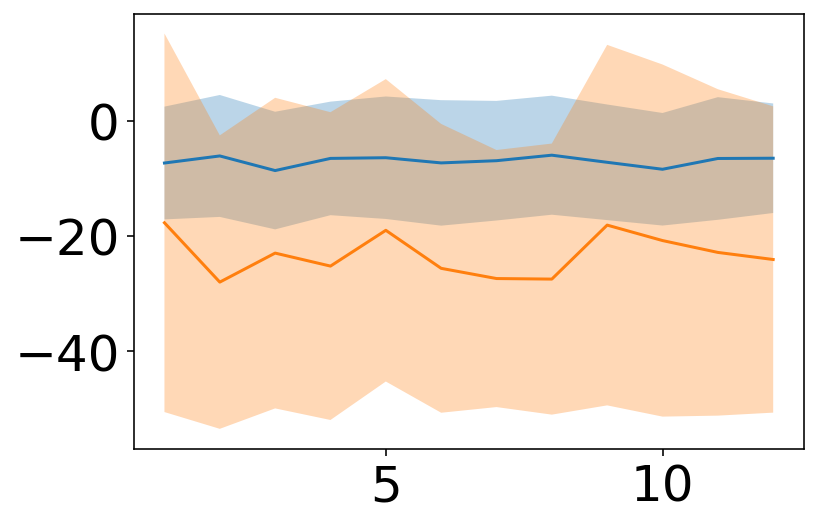

In [175]:
fig, ax = plt.subplots()
mean_std = np.array([[df[col][month - 1].mean(), df[col][month - 1].std()] 
                     for month in df['month'] 
                     for col in ['t_change']])
meanst = mean_std[:,0]
sdt = mean_std[:,1]
ax.plot(df['month'], meanst)
ax.fill_between(df['month'], meanst-sdt, meanst+sdt ,alpha=0.3)

mean_std = np.array([[df[col][month - 1].mean(), df[col][month - 1].std()] 
                     for month in df['month'] 
                     for col in ['td_change']])
meanst = mean_std[:,0]
sdt = mean_std[:,1]
ax.plot(df['month'], meanst)
ax.fill_between(df['month'], meanst-sdt, meanst+sdt ,alpha=0.3)

# mean_std = np.array([[df[col][month - 1].mean(), df[col][month - 1].std()] 
#                      for month in df['month'] 
#                      for col in ['t_rmse']])
# meanst = mean_std[:,0]
# sdt = mean_std[:,1]
# ax.plot(df['month'], meanst)
# ax.fill_between(df['month'], meanst-sdt, meanst+sdt ,alpha=0.3)

# mean_std = np.array([[df[col][month - 1].mean(), df[col][month - 1].std()] 
#                      for month in df['month'] 
#                      for col in ['og_t_rmse']])
# meanst = mean_std[:,0]
# sdt = mean_std[:,1]
# ax.plot(df['month'], meanst)
# ax.fill_between(df['month'], meanst-sdt, meanst+sdt ,alpha=0.3)



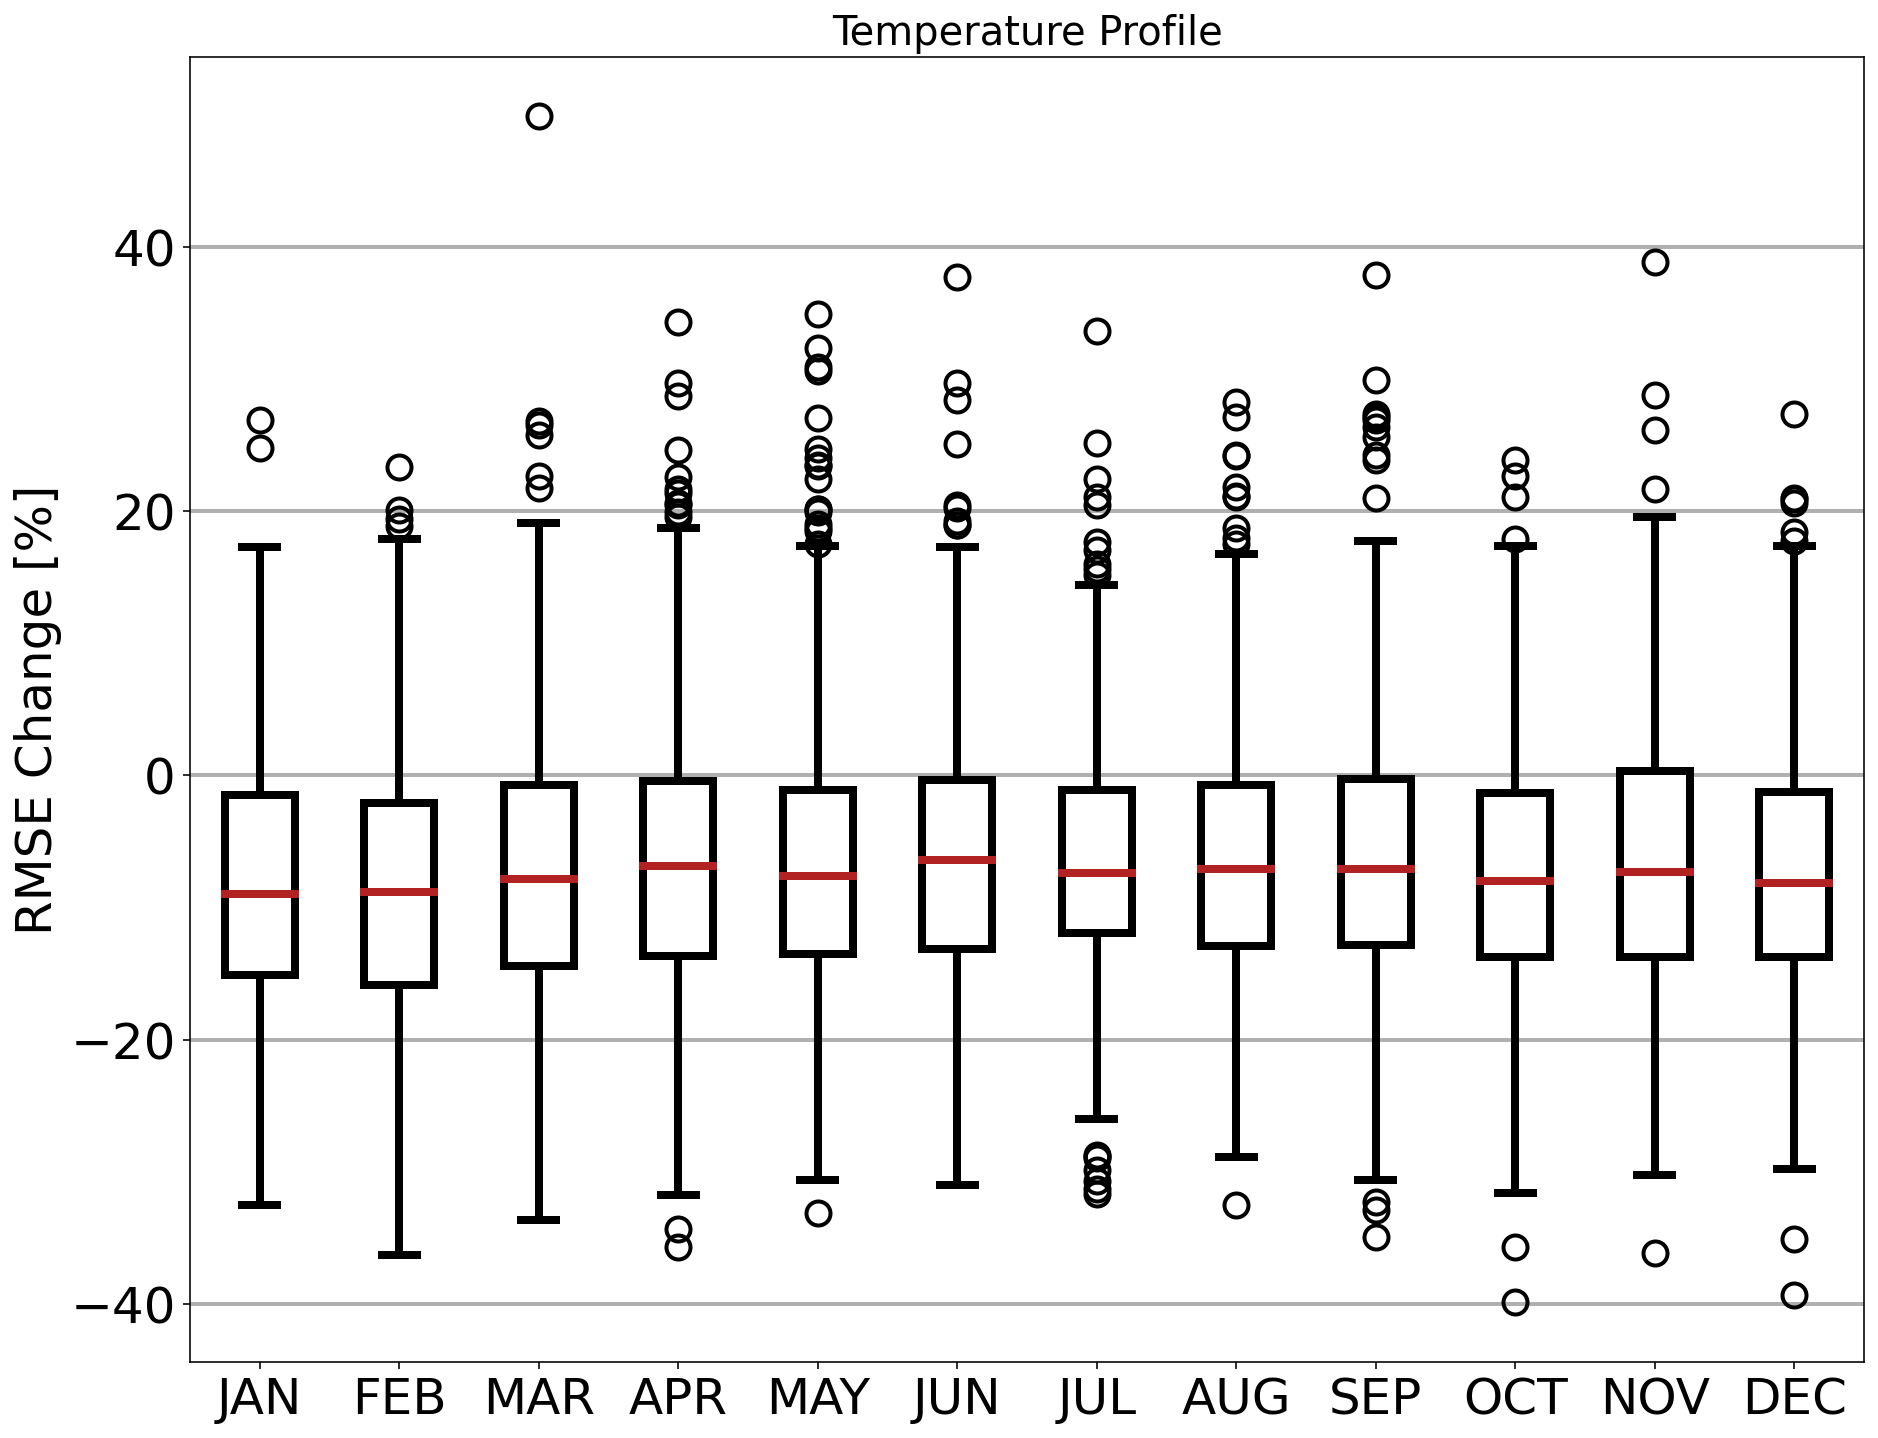

In [97]:
radiosonde_plotting.plot_monthly_error(df['t_change'].values, df['month'].values, 'Temperature Profile', y_label='RMSE Change [%]',
                                       file_name='/home/stock/research/media/temperature_monthly_change_error.png');

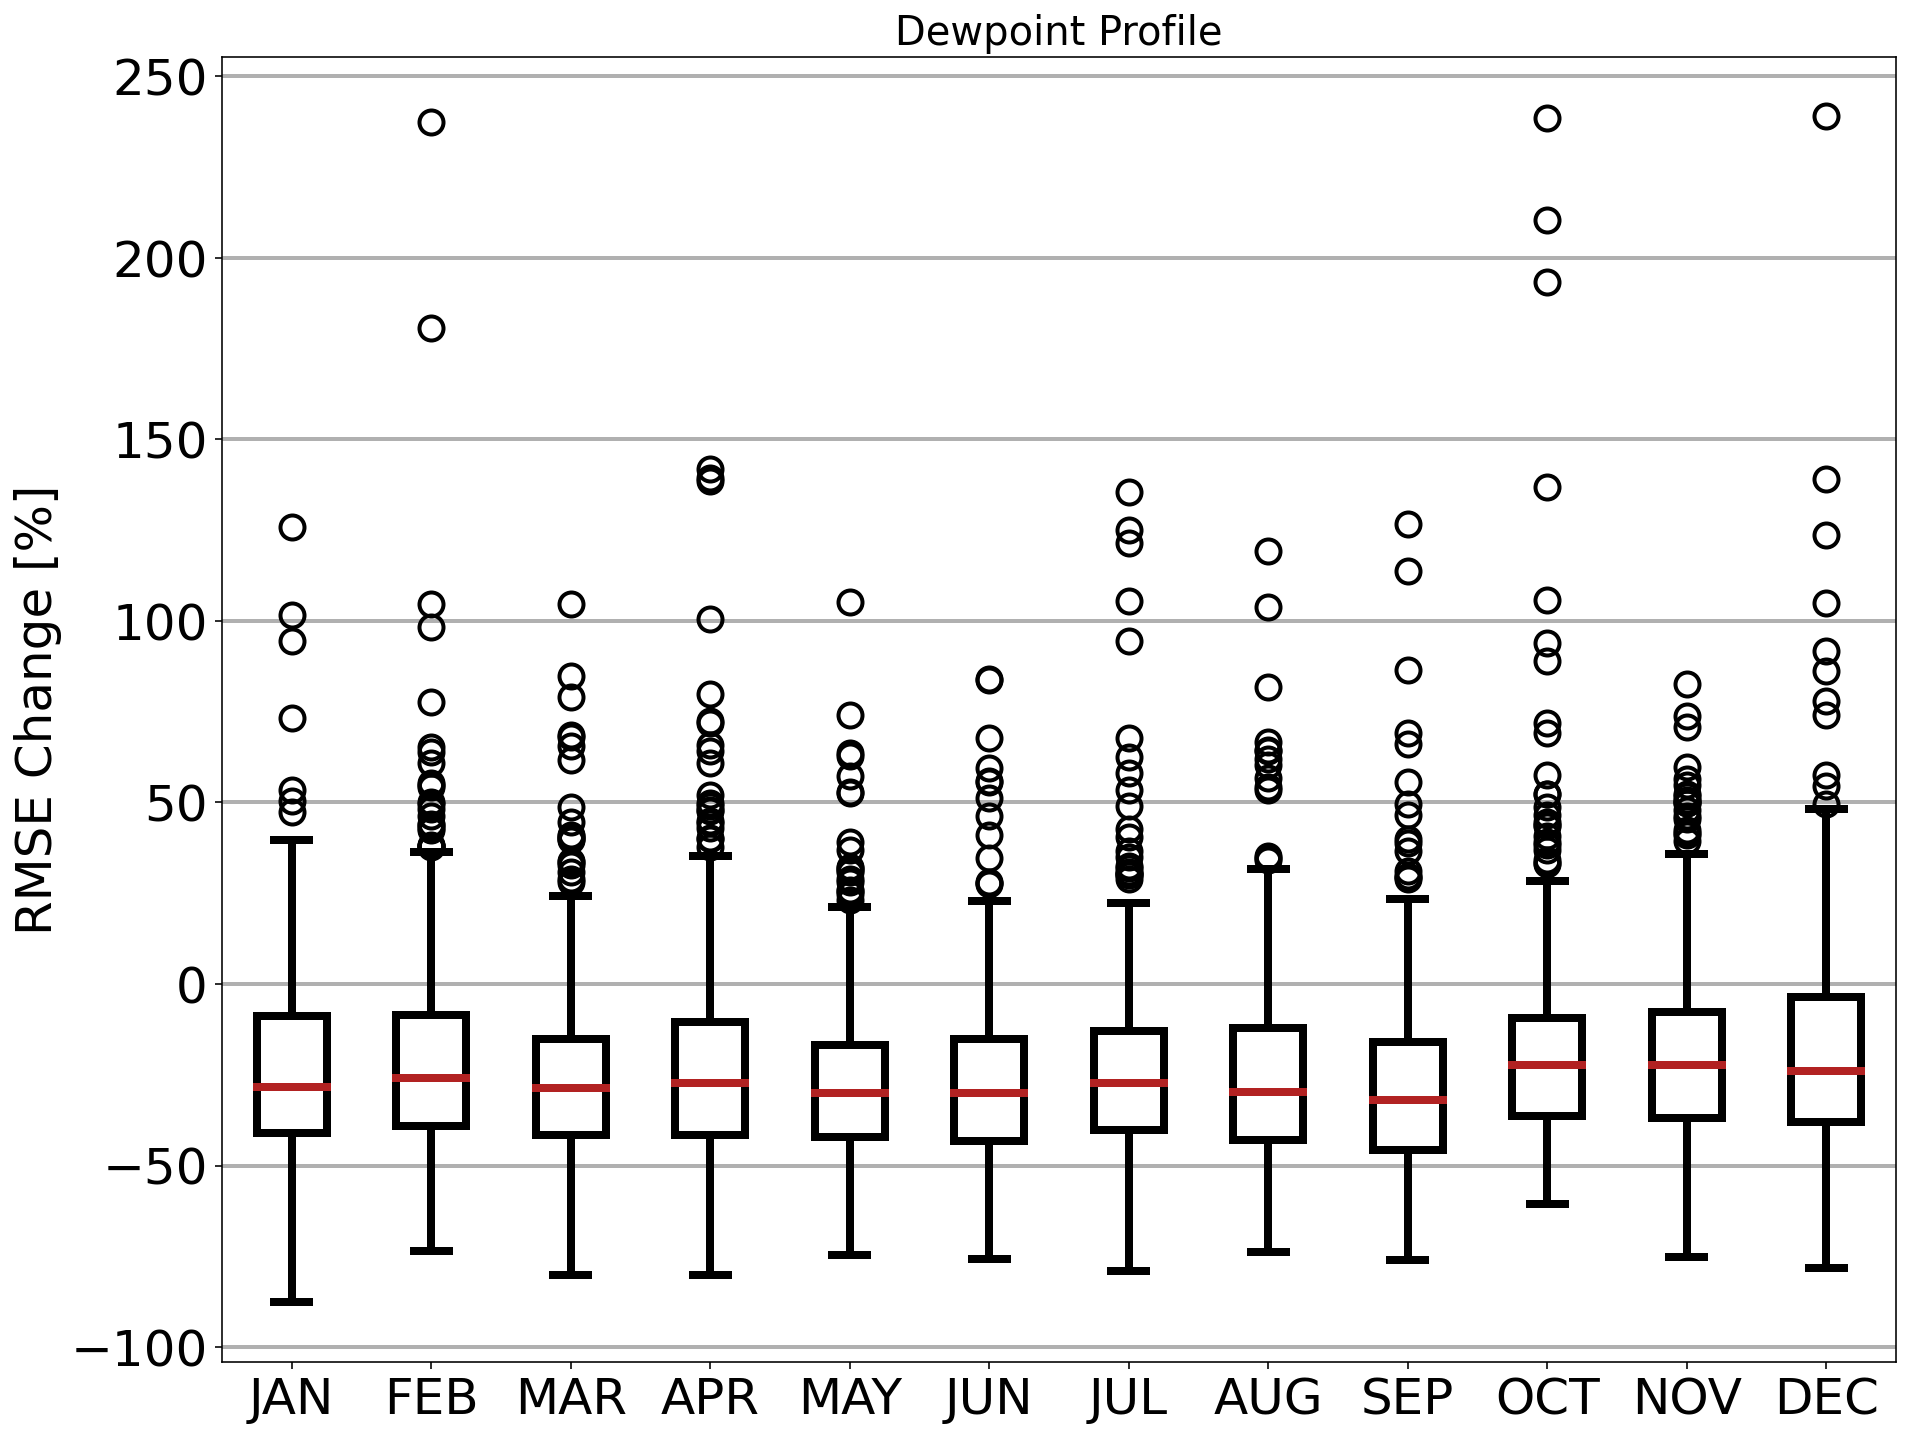

In [98]:
radiosonde_plotting.plot_monthly_error(df['td_change'].values, df['month'].values, 'Dewpoint Profile', y_label='RMSE Change [%]',
                                       file_name='/home/stock/research/media/dewpoint_monthly_change_error.png');

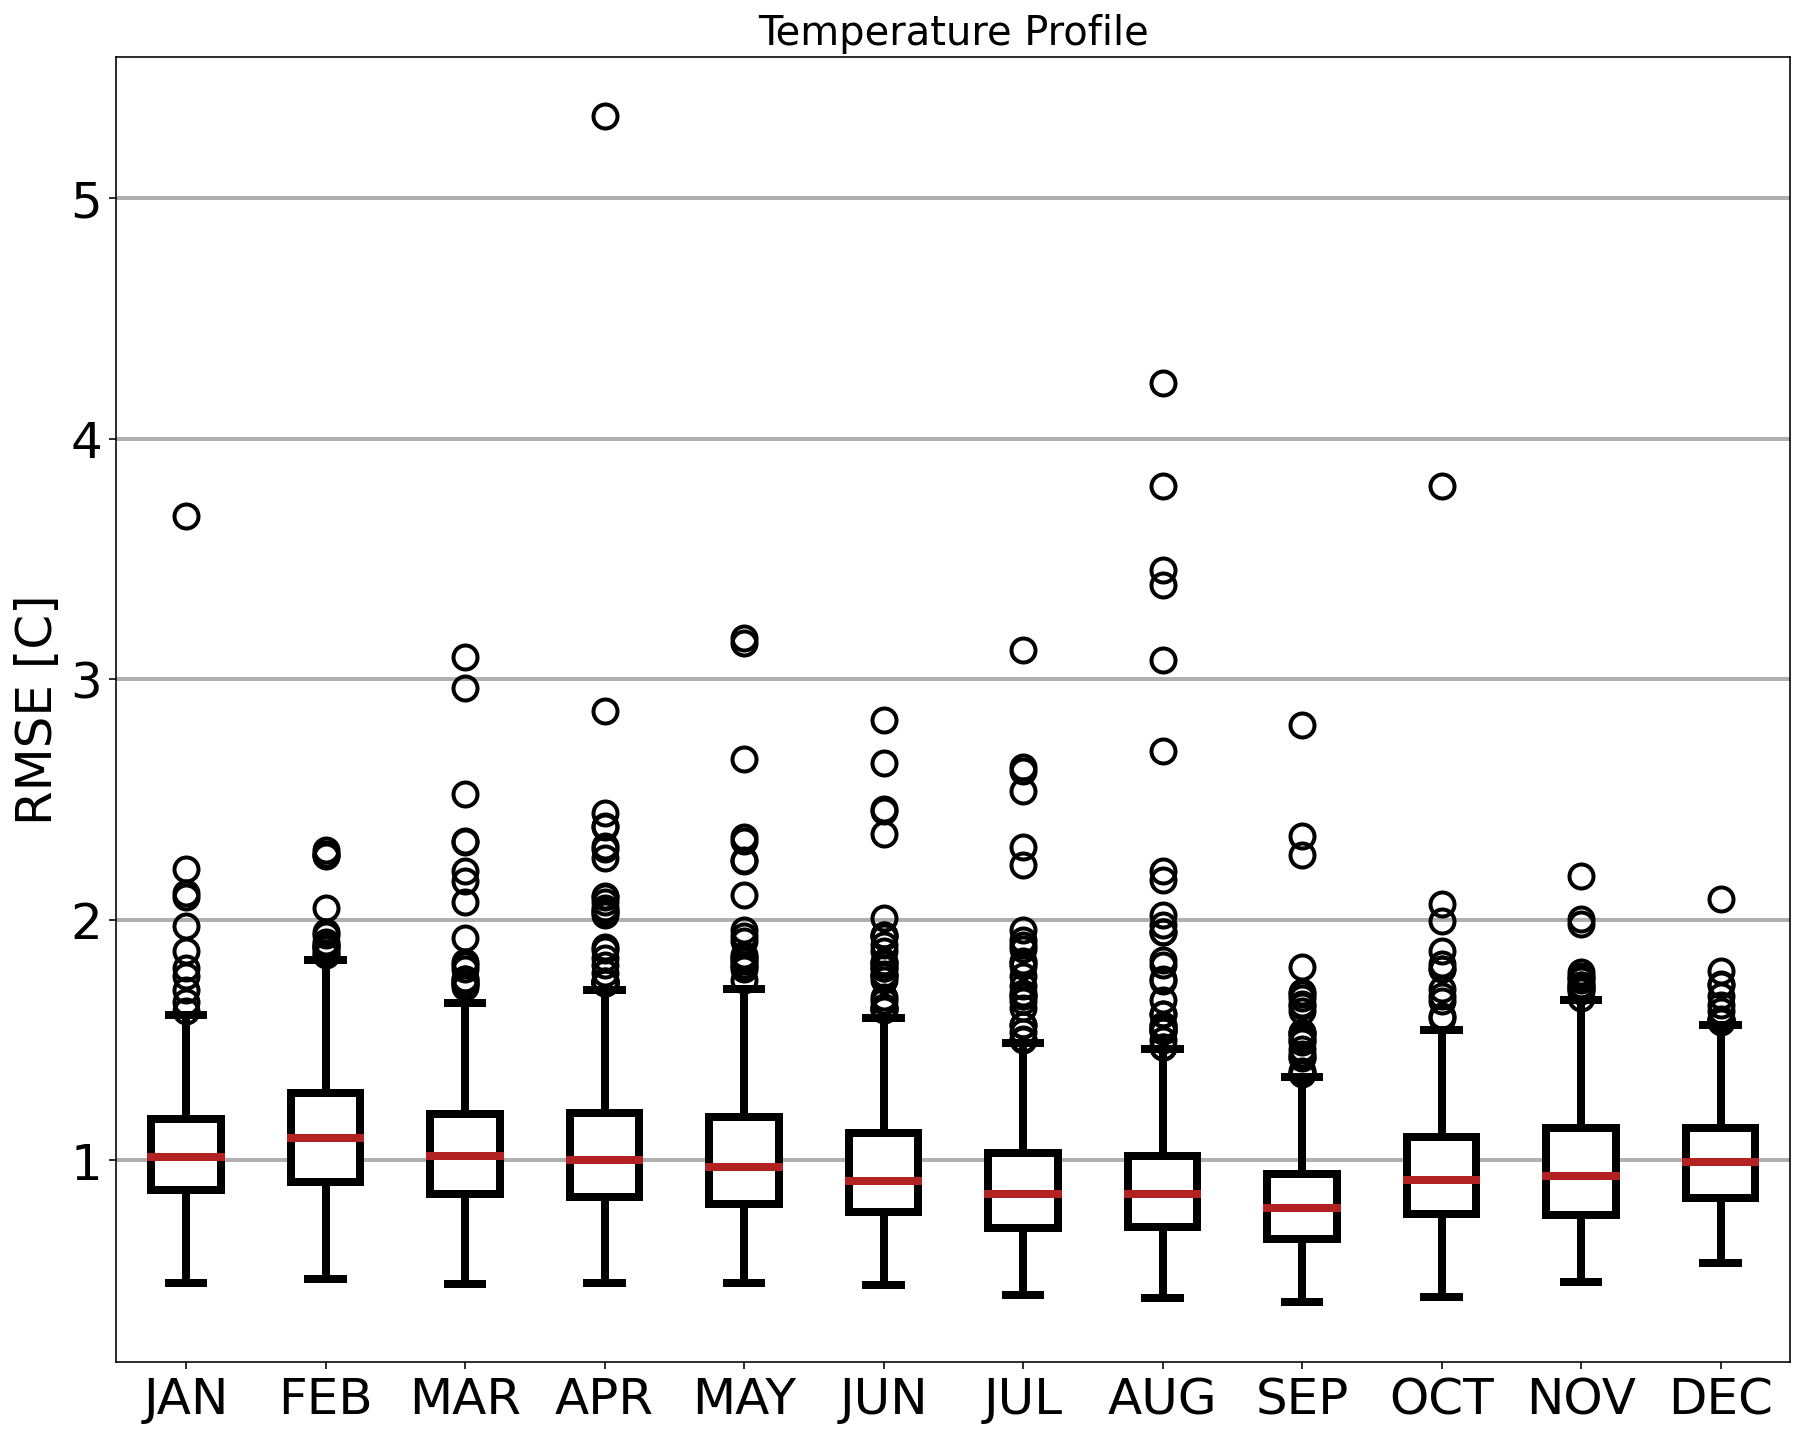

In [177]:
radiosonde_plotting.plot_monthly_error(df['og_t_rmse'].values, df['month'].values, 'Temperature Profile', 
                                       file_name='/home/stock/research/media/temperature_monthly_rap_error.png');

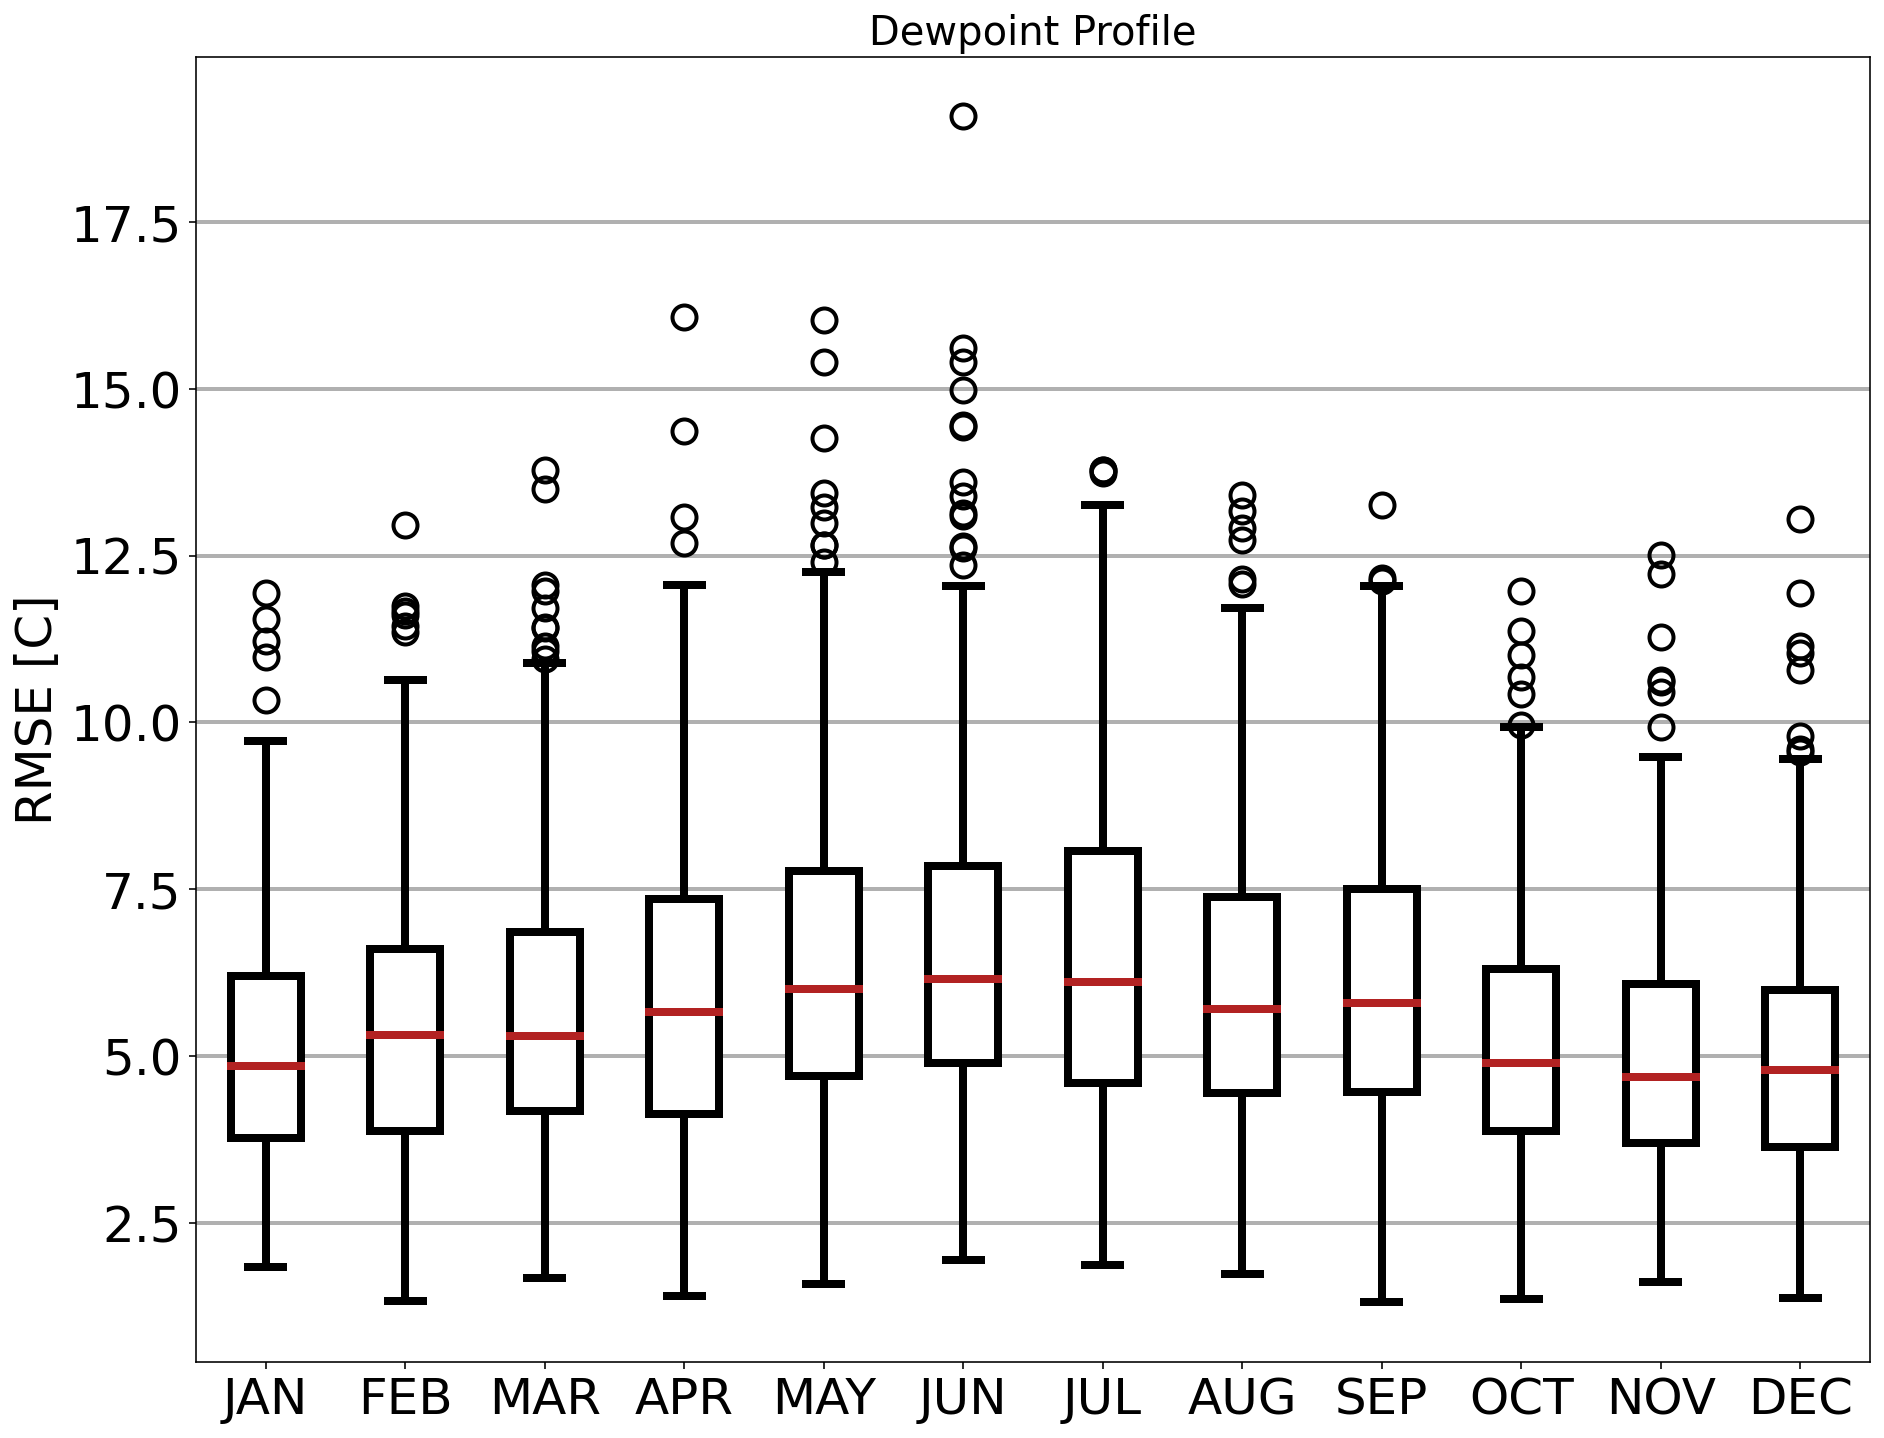

In [176]:
radiosonde_plotting.plot_monthly_error(df['og_td_rmse'].values, df['month'].values, 'Dewpoint Profile',
                                       file_name='/home/stock/research/media/dewpoint_monthly_rap_error.png');